<a href="https://colab.research.google.com/github/its-Shivam732/XrayDenoise/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies
!pip install torch torchvision diffusers accelerate scikit-image pytorch-fid pillow -q

# Import libraries
import os
import torch
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage.util import random_noise
from google.colab import drive
import glob
from PIL import Image
import shutil
import zipfile

# Mount Google Drive for persistent storage
drive.mount('/content/drive', force_remount=True)
output_dir = '/content/drive/MyDrive/xray_denoising_dataset'
os.makedirs(output_dir, exist_ok=True)

# ============================================
# DOWNLOAD DATASET USING KAGGLE API
# ============================================

# Setup Kaggle API
os.makedirs('/root/.kaggle', exist_ok=True)

# Upload your kaggle.json file
print("Please upload your kaggle.json file:")
print("1. Go to https://www.kaggle.com/settings/account")
print("2. Scroll to 'API' section and click 'Create New Token'")
print("3. Upload the downloaded kaggle.json file when prompted below")

from google.colab import files
uploaded = files.upload()  # This will prompt you to upload kaggle.json

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
dataset_root = '/content/covid_xray/COVID-19_Radiography_Dataset'

if not os.path.exists(dataset_root):
    print("\nDownloading COVID-19 Radiography Dataset from Kaggle...")

    # Download dataset
    !kaggle datasets download -d tawsifurrahman/covid19-radiography-database -p /content/covid_xray

    # Extract the zip file
    print("\nExtracting dataset...")
    zip_path = '/content/covid_xray/covid19-radiography-database.zip'

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/covid_xray')

    # Remove zip file to save space
    os.remove(zip_path)

    print("✓ Dataset downloaded and extracted successfully!")

    # Verify the structure
    if os.path.exists(dataset_root):
        print(f"✓ Dataset verified at {dataset_root}")
    else:
        # Sometimes the extracted folder has a different name
        # List what's actually in the directory
        print("\nContents of /content/covid_xray:")
        !ls -la /content/covid_xray

        # Try to find the actual dataset folder
        for item in os.listdir('/content/covid_xray'):
            item_path = os.path.join('/content/covid_xray', item)
            if os.path.isdir(item_path):
                print(f"\nFound directory: {item_path}")
                # Update dataset_root to the actual path
                dataset_root = item_path
                break
else:
    print(f"✓ Dataset already exists at {dataset_root}")

# Verify dataset directory
if not os.path.exists(dataset_root):
    raise FileNotFoundError(f"Dataset root not found at {dataset_root}")

# Get all image paths from subdirectories
def collect_image_paths(root_dir):
    """Collect all image paths from the dataset structure"""
    image_paths = []
    categories = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']

    for category in categories:
        images_dir = os.path.join(root_dir, category, 'images')
        if os.path.exists(images_dir):
            # Get all PNG and JPEG files
            png_files = glob.glob(os.path.join(images_dir, '*.png'))
            jpg_files = glob.glob(os.path.join(images_dir, '*.jpg'))
            jpeg_files = glob.glob(os.path.join(images_dir, '*.jpeg'))

            category_images = png_files + jpg_files + jpeg_files
            image_paths.extend(category_images)
            print(f"Found {len(category_images)} images in {category}")

    return image_paths

# Continue with rest of your code...

Mounted at /content/drive
Please upload your kaggle.json file:
1. Go to https://www.kaggle.com/settings/account
2. Scroll to 'API' section and click 'Create New Token'
3. Upload the downloaded kaggle.json file when prompted below


Saving kaggle.json to kaggle.json

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 95% 739M/778M [00:04<00:00, 130MB/s]
100% 778M/778M [00:04<00:00, 189MB/s]

Extracting dataset...
✓ Dataset downloaded and extracted successfully!
✓ Dataset verified at /content/covid_xray/COVID-19_Radiography_Dataset


In [2]:
# Install dependencies
!pip install torch torchvision diffusers accelerate scikit-image pytorch-fid pillow

# Import libraries
import os
import torch
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage.util import random_noise
from google.colab import drive
import glob
from PIL import Image

# Mount Google Drive for persistent storage
drive.mount('/content/drive', force_remount=True)
output_dir = '/content/drive/MyDrive/xray_denoising_dataset'
os.makedirs(output_dir, exist_ok=True)

# Verify dataset directory
dataset_root = '/content/covid_xray/COVID-19_Radiography_Dataset'
if not os.path.exists(dataset_root):
    raise FileNotFoundError(f"Dataset root not found at {dataset_root}")

# Get all image paths from subdirectories
def collect_image_paths(root_dir):
    """Collect all image paths from the dataset structure"""
    image_paths = []
    categories = ['Normal', 'COVID', 'Lung_Opacity', 'Viral_Pneumonia']

    for category in categories:
        images_dir = os.path.join(root_dir, category, 'images')
        if os.path.exists(images_dir):
            # Get all PNG and JPEG files
            png_files = glob.glob(os.path.join(images_dir, '*.png'))
            jpg_files = glob.glob(os.path.join(images_dir, '*.jpg'))
            jpeg_files = glob.glob(os.path.join(images_dir, '*.jpeg'))

            category_images = png_files + jpg_files + jpeg_files
            image_paths.extend(category_images)
            print(f"Found {len(category_images)} images in {category}")

    return image_paths

# Collect all image paths
all_image_paths = collect_image_paths(dataset_root)
print(f"\nTotal images found: {len(all_image_paths)}")

if len(all_image_paths) == 0:
    raise FileNotFoundError("No images found! Check the directory structure.")

# Limit to 2000 images for faster processing
all_image_paths = all_image_paths[:2000]
print(f"Using {len(all_image_paths)} images for this run")

# Custom Dataset class
class XRayDataset(Dataset):
    def __init__(self, image_paths, transform=None, noise_type='gaussian', noise_level=0.1):
        self.image_paths = image_paths
        self.transform = transform
        self.noise_type = noise_type
        self.noise_level = noise_level

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            # Load image
            image_path = self.image_paths[idx]
            image = Image.open(image_path).convert('L')  # Grayscale

            # Resize to 256x256
            image = image.resize((256, 256), Image.Resampling.LANCZOS)

            # Convert to numpy array and normalize to [0,1]
            image = np.array(image, dtype=np.float32) / 255.0

            # Add noise
            if self.noise_type == 'gaussian':
                noisy = random_noise(image, mode='gaussian', var=self.noise_level**2, clip=True)
            elif self.noise_type == 'poisson':
                noisy = random_noise(image, mode='poisson', clip=True)
            else:
                noisy = image.copy()

            # Convert to tensors [1, H, W]
            image_tensor = torch.from_numpy(image).unsqueeze(0).float()
            noisy_tensor = torch.from_numpy(noisy.astype(np.float32)).unsqueeze(0).float()

            # Apply normalization to [-1, 1] if transform provided
            if self.transform:
                image_tensor = self.transform(image_tensor)
                noisy_tensor = self.transform(noisy_tensor)

            return {'clean': image_tensor, 'noisy': noisy_tensor}

        except Exception as e:
            print(f"Error processing image {idx} ({self.image_paths[idx]}): {e}")
            # Return a blank image pair as fallback
            blank = torch.zeros(1, 256, 256)
            return {'clean': blank, 'noisy': blank}

# Preprocessing transform (normalization only)
transform = transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]

# Split dataset
train_size = 1500
val_size = min(500, len(all_image_paths) - train_size)

train_paths = all_image_paths[:train_size]
val_paths = all_image_paths[train_size:train_size + val_size]

print(f"\nCreating datasets...")
print(f"Train: {len(train_paths)} images")
print(f"Val: {len(val_paths)} images")

# Create datasets
train_dataset = XRayDataset(train_paths, transform=transform, noise_type='gaussian', noise_level=0.1)
val_dataset = XRayDataset(val_paths, transform=transform, noise_type='gaussian', noise_level=0.1)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nDataLoaders created successfully!")

# Save sample images
def save_samples(loader, num_samples=5, output_dir=output_dir):
    samples_dir = os.path.join(output_dir, 'samples')
    os.makedirs(samples_dir, exist_ok=True)

    try:
        batch = next(iter(loader))
        num_to_save = min(num_samples, len(batch['clean']))

        for i in range(num_to_save):
            # Denormalize from [-1, 1] to [0, 1]
            clean = (batch['clean'][i].squeeze().numpy() * 0.5 + 0.5).clip(0, 1)
            noisy = (batch['noisy'][i].squeeze().numpy() * 0.5 + 0.5).clip(0, 1)

            # Create comparison figure
            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(clean, cmap='gray', vmin=0, vmax=1)
            plt.title('Clean X-Ray', fontsize=14)
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(noisy, cmap='gray', vmin=0, vmax=1)
            plt.title(f'Noisy (Gaussian σ=0.1)', fontsize=14)
            plt.axis('off')

            plt.tight_layout()
            plt.savefig(os.path.join(samples_dir, f'sample_{i}.png'), dpi=150, bbox_inches='tight')
            plt.close()

        print(f"Saved {num_to_save} sample pairs to {samples_dir}")

    except Exception as e:
        print(f"Error saving samples: {e}")

# Save samples from training set
print("\nGenerating sample images...")
save_samples(train_loader, num_samples=8)

# Save metadata
metadata_path = os.path.join(output_dir, 'metadata.txt')
with open(metadata_path, 'w') as f:
    f.write('X-Ray Denoising Dataset\n')
    f.write('='*50 + '\n\n')
    f.write(f'Source: COVID-19 Radiography Database\n')
    f.write(f'Dataset root: {dataset_root}\n\n')
    f.write(f'Training images: {len(train_paths)}\n')
    f.write(f'Validation images: {len(val_paths)}\n')
    f.write(f'Total images: {len(all_image_paths)}\n\n')
    f.write(f'Image specifications:\n')
    f.write(f'  - Size: 256x256 pixels\n')
    f.write(f'  - Format: Grayscale\n')
    f.write(f'  - Normalization: [-1, 1]\n\n')
    f.write(f'Noise configuration:\n')
    f.write(f'  - Type: Gaussian\n')
    f.write(f'  - Standard deviation (σ): 0.1\n')
    f.write(f'  - Variance: 0.01\n\n')
    f.write(f'DataLoader settings:\n')
    f.write(f'  - Batch size: 16\n')
    f.write(f'  - Num workers: 2\n')
    f.write(f'  - Pin memory: True\n')

print(f"\nMetadata saved to {metadata_path}")

# Test loading a batch
print("\nTesting data loading...")
try:
    test_batch = next(iter(train_loader))
    print(f"✓ Successfully loaded batch!")
    print(f"  - Clean images shape: {test_batch['clean'].shape}")
    print(f"  - Noisy images shape: {test_batch['noisy'].shape}")
    print(f"  - Clean images range: [{test_batch['clean'].min():.3f}, {test_batch['clean'].max():.3f}]")
    print(f"  - Noisy images range: [{test_batch['noisy'].min():.3f}, {test_batch['noisy'].max():.3f}]")
except Exception as e:
    print(f"✗ Error loading batch: {e}")

# Initialize PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n{'='*50}")
print(f"Setup complete!")
print(f"Device: {device}")
print(f"Output directory: {output_dir}")
print(f"{'='*50}\n")

# Print summary
print("Dataset is ready for training!")
print(f"Access training data with: train_loader")
print(f"Access validation data with: val_loader")
print(f"Check samples at: {os.path.join(output_dir, 'samples')}")

Mounted at /content/drive
Found 10192 images in Normal
Found 3616 images in COVID
Found 6012 images in Lung_Opacity

Total images found: 19820
Using 2000 images for this run

Creating datasets...
Train: 1500 images
Val: 500 images

DataLoaders created successfully!

Generating sample images...
Saved 8 sample pairs to /content/drive/MyDrive/xray_denoising_dataset/samples

Metadata saved to /content/drive/MyDrive/xray_denoising_dataset/metadata.txt

Testing data loading...
✓ Successfully loaded batch!
  - Clean images shape: torch.Size([16, 1, 256, 256])
  - Noisy images shape: torch.Size([16, 1, 256, 256])
  - Clean images range: [-1.000, 1.000]
  - Noisy images range: [-1.000, 1.000]

Setup complete!
Device: cuda
Output directory: /content/drive/MyDrive/xray_denoising_dataset

Dataset is ready for training!
Access training data with: train_loader
Access validation data with: val_loader
Check samples at: /content/drive/MyDrive/xray_denoising_dataset/samples


In [3]:
# Install additional packages if needed
!pip install scikit-image -q

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

print("✓ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


✓ All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4


In [4]:
# ============================================================================
# CELL 1: Data Preparation (Run after dataset download)
# ============================================================================

# Collect all image paths
all_image_paths = collect_image_paths(dataset_root)
print(f"\nTotal images found: {len(all_image_paths)}")

if len(all_image_paths) == 0:
    raise FileNotFoundError("No images found! Check the directory structure.")

# Limit to 2000 images for faster processing
all_image_paths = all_image_paths[:2000]
print(f"Using {len(all_image_paths)} images for this run")

# Custom Dataset class
class XRayDataset(Dataset):
    def __init__(self, image_paths, transform=None, noise_type='gaussian', noise_level=0.1):
        self.image_paths = image_paths
        self.transform = transform
        self.noise_type = noise_type
        self.noise_level = noise_level

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            # Load image
            image_path = self.image_paths[idx]
            image = Image.open(image_path).convert('L')  # Grayscale

            # Resize to 256x256
            image = image.resize((256, 256), Image.Resampling.LANCZOS)

            # Convert to numpy array and normalize to [0,1]
            image = np.array(image, dtype=np.float32) / 255.0

            # Add noise
            if self.noise_type == 'gaussian':
                noisy = random_noise(image, mode='gaussian', var=self.noise_level**2, clip=True)
            elif self.noise_type == 'poisson':
                noisy = random_noise(image, mode='poisson', clip=True)
            else:
                noisy = image.copy()

            # Convert to tensors [1, H, W]
            image_tensor = torch.from_numpy(image).unsqueeze(0).float()
            noisy_tensor = torch.from_numpy(noisy.astype(np.float32)).unsqueeze(0).float()

            # Apply normalization to [-1, 1] if transform provided
            if self.transform:
                image_tensor = self.transform(image_tensor)
                noisy_tensor = self.transform(noisy_tensor)

            return {'clean': image_tensor, 'noisy': noisy_tensor}

        except Exception as e:
            print(f"Error processing image {idx} ({self.image_paths[idx]}): {e}")
            blank = torch.zeros(1, 256, 256)
            return {'clean': blank, 'noisy': blank}

# Preprocessing transform
transform = transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]

# Split dataset
train_size = 1500
val_size = min(500, len(all_image_paths) - train_size)

train_paths = all_image_paths[:train_size]
val_paths = all_image_paths[train_size:train_size + val_size]

print(f"\nCreating datasets...")
print(f"Train: {len(train_paths)} images")
print(f"Val: {len(val_paths)} images")

# Create datasets
train_dataset = XRayDataset(train_paths, transform=transform, noise_type='gaussian', noise_level=0.1)
val_dataset = XRayDataset(val_paths, transform=transform, noise_type='gaussian', noise_level=0.1)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

# Test loading
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_batch = next(iter(train_loader))
print(f"\n✓ DataLoaders created successfully!")
print(f"  Device: {device}")
print(f"  Batch shape: {test_batch['clean'].shape}")
print(f"  Data range: [{test_batch['clean'].min():.3f}, {test_batch['clean'].max():.3f}]")

Found 10192 images in Normal
Found 3616 images in COVID
Found 6012 images in Lung_Opacity

Total images found: 19820
Using 2000 images for this run

Creating datasets...
Train: 1500 images
Val: 500 images

✓ DataLoaders created successfully!
  Device: cuda
  Batch shape: torch.Size([16, 1, 256, 256])
  Data range: [-1.000, 1.000]


In [5]:
# ============================================================================
# CELL 2: MAE Encoder Architecture (Vision Transformer-based)
# ============================================================================

import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    """Convert image into patches and embed them"""
    def __init__(self, img_size=256, patch_size=16, in_channels=1, embed_dim=256):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.grid_size = img_size // patch_size

        # Use conv2d for efficient patch embedding
        self.proj = nn.Conv2d(in_channels, embed_dim,
                             kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        """
        Args:
            x: [B, C, H, W]
        Returns:
            patches: [B, num_patches, embed_dim]
        """
        # x: [B, 1, 256, 256] -> [B, embed_dim, 16, 16]
        x = self.proj(x)
        # Flatten: [B, embed_dim, 16, 16] -> [B, embed_dim, 256]
        x = x.flatten(2)
        # Transpose: [B, embed_dim, 256] -> [B, 256, embed_dim]
        x = x.transpose(1, 2)
        return x


class MAEEncoder(nn.Module):
    """
    Masked Autoencoder Encoder
    Uses Vision Transformer (ViT) blocks to encode patches
    """
    def __init__(self, img_size=256, patch_size=16, in_channels=1,
                 embed_dim=256, depth=4, num_heads=8, mlp_ratio=4.0):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.num_patches = self.patch_embed.num_patches

        # Learnable positional embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))

        # Transformer encoder blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)

        # Initialize positional embeddings
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, x, mask_indices=None):
        """
        Args:
            x: [B, C, H, W] input images
            mask_indices: [B, num_masked] indices of patches to keep (for MAE pretraining)
        Returns:
            encoded: [B, num_patches (or num_visible), embed_dim]
        """
        # Patch embedding
        x = self.patch_embed(x)  # [B, num_patches, embed_dim]

        # Add positional embedding
        x = x + self.pos_embed

        # Apply mask if provided (for MAE pretraining)
        if mask_indices is not None:
            B, N, D = x.shape
            # Keep only visible patches
            x = torch.gather(x, 1, mask_indices.unsqueeze(-1).expand(-1, -1, D))

        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        return x


class TransformerBlock(nn.Module):
    """Standard Transformer block with multi-head attention and MLP"""
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()

        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                         dropout=dropout, batch_first=True)

        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Self-attention with residual
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        # MLP with residual
        x = x + self.mlp(self.norm2(x))
        return x


# Test the encoder
print("Testing MAE Encoder...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_encoder = MAEEncoder(
    img_size=256,
    patch_size=16,
    in_channels=1,
    embed_dim=256,
    depth=4,
    num_heads=8
).to(device)

test_input = torch.randn(2, 1, 256, 256).to(device)
test_output = test_encoder(test_input)

print(f"✓ Encoder created successfully!")
print(f"  Input shape:  {test_input.shape}")
print(f"  Output shape: {test_output.shape}")
print(f"  Parameters:   {sum(p.numel() for p in test_encoder.parameters()):,}")

del test_encoder, test_input, test_output
torch.cuda.empty_cache()

Testing MAE Encoder...
✓ Encoder created successfully!
  Input shape:  torch.Size([2, 1, 256, 256])
  Output shape: torch.Size([2, 256, 256])
  Parameters:   3,290,880


In [6]:
# ============================================================================
# CELL 3: MAE Decoder Architecture (Convolutional + Refinement)
# ============================================================================

class ConvDecoder(nn.Module):
    """
    Convolutional decoder for image reconstruction
    Converts encoded patches back to full resolution image
    """
    def __init__(self, img_size=256, patch_size=16, embed_dim=256, out_channels=1):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.grid_size = img_size // patch_size

        # Project from embed_dim to patch pixels
        self.decoder_pred = nn.Linear(embed_dim, patch_size * patch_size * out_channels)

        # Refinement CNN to improve reconstruction quality
        self.refine = nn.Sequential(
            nn.Conv2d(out_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):
        """
        Args:
            x: [B, num_patches, embed_dim]
        Returns:
            reconstructed: [B, C, H, W]
        """
        B = x.shape[0]

        # Linear projection to patch pixels
        x = self.decoder_pred(x)  # [B, num_patches, patch_size^2 * C]

        # Reshape to patches
        # [B, num_patches, patch_size * patch_size * C]
        x = x.reshape(B, self.grid_size, self.grid_size,
                     self.patch_size, self.patch_size, -1)

        # Rearrange patches to image
        # [B, grid_h, grid_w, patch_h, patch_w, C] -> [B, C, H, W]
        x = x.permute(0, 5, 1, 3, 2, 4).contiguous()
        x = x.reshape(B, -1, self.img_size, self.img_size)

        # Refine with CNN
        x = self.refine(x)

        return x


# Test the decoder
print("Testing ConvDecoder...")
test_decoder = ConvDecoder(
    img_size=256,
    patch_size=16,
    embed_dim=256,
    out_channels=1
).to(device)

# Test with encoded features (256 patches, 256 dims each)
test_encoded = torch.randn(2, 256, 256).to(device)
test_reconstructed = test_decoder(test_encoded)

print(f"✓ Decoder created successfully!")
print(f"  Input shape:  {test_encoded.shape}")
print(f"  Output shape: {test_reconstructed.shape}")
print(f"  Parameters:   {sum(p.numel() for p in test_decoder.parameters()):,}")

del test_decoder, test_encoded, test_reconstructed
torch.cuda.empty_cache()

Testing ConvDecoder...
✓ Decoder created successfully!
  Input shape:  torch.Size([2, 256, 256])
  Output shape: torch.Size([2, 1, 256, 256])
  Parameters:   122,433


In [7]:
# ============================================================================
# CELL 4: Complete MAE Denoising Autoencoder
# ============================================================================

class MAEDenoisingAutoencoder(nn.Module):
    """
    MAE-Enhanced Denoising Autoencoder

    Two-stage training:
    1. MAE Pretraining: Self-supervised learning on masked patches
    2. Denoising Fine-tuning: Supervised learning for denoising
    """
    def __init__(self, img_size=256, patch_size=16, in_channels=1,
                 embed_dim=256, depth=4, num_heads=8):
        super().__init__()

        self.encoder = MAEEncoder(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads
        )

        self.decoder = ConvDecoder(
            img_size=img_size,
            patch_size=patch_size,
            embed_dim=embed_dim,
            out_channels=in_channels
        )

        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

    def forward(self, x, mask_indices=None):
        """
        Args:
            x: [B, C, H, W] input images
            mask_indices: Optional mask for MAE pretraining
        Returns:
            reconstructed: [B, C, H, W]
        """
        # Encode
        encoded = self.encoder(x, mask_indices)

        # For MAE pretraining with masking, we need to handle partial encoding
        if mask_indices is not None:
            # Expand back to full number of patches (fill masked with zeros)
            B, num_visible, D = encoded.shape
            full_encoded = torch.zeros(B, self.num_patches, D,
                                      device=encoded.device, dtype=encoded.dtype)
            full_encoded.scatter_(1, mask_indices.unsqueeze(-1).expand(-1, -1, D), encoded)
            encoded = full_encoded

        # Decode
        reconstructed = self.decoder(encoded)

        return reconstructed

    def get_latent_representation(self, x):
        """Extract latent representations for visualization"""
        with torch.no_grad():
            encoded = self.encoder(x)
            return encoded

    def random_masking(self, batch_size, mask_ratio=0.75):
        """
        Generate random masking indices for MAE pretraining

        Args:
            batch_size: Batch size
            mask_ratio: Proportion of patches to mask
        Returns:
            keep_indices: Indices of patches to keep (visible)
        """
        num_keep = int(self.num_patches * (1 - mask_ratio))

        # Generate random permutation for each sample in batch
        noise = torch.rand(batch_size, self.num_patches, device=device)
        ids_shuffle = torch.argsort(noise, dim=1)

        # Keep first num_keep patches
        keep_indices = ids_shuffle[:, :num_keep]

        return keep_indices


# Create the complete model
print("Creating MAE Denoising Autoencoder...")
model = MAEDenoisingAutoencoder(
    img_size=256,
    patch_size=16,
    in_channels=1,
    embed_dim=256,
    depth=4,
    num_heads=8
).to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model created successfully!")
print(f"  Total parameters: {num_params:,}")
print(f"  Model size: ~{num_params * 4 / 1024 / 1024:.2f} MB")

# Test forward pass
test_input = torch.randn(2, 1, 256, 256).to(device)

# Test without masking (denoising mode)
test_output = model(test_input)
print(f"\n✓ Denoising mode:")
print(f"  Input:  {test_input.shape}")
print(f"  Output: {test_output.shape}")

# Test with masking (MAE pretraining mode)
mask_indices = model.random_masking(batch_size=2, mask_ratio=0.75)
test_output_masked = model(test_input, mask_indices)
print(f"\n✓ MAE pretraining mode (75% masked):")
print(f"  Input:  {test_input.shape}")
print(f"  Visible patches: {mask_indices.shape[1]} / {model.num_patches}")
print(f"  Output: {test_output_masked.shape}")

del test_input, test_output, test_output_masked
torch.cuda.empty_cache()

print("\n✓ Model ready for training!")

Creating MAE Denoising Autoencoder...
✓ Model created successfully!
  Total parameters: 3,413,313
  Model size: ~13.02 MB

✓ Denoising mode:
  Input:  torch.Size([2, 1, 256, 256])
  Output: torch.Size([2, 1, 256, 256])

✓ MAE pretraining mode (75% masked):
  Input:  torch.Size([2, 1, 256, 256])
  Visible patches: 64 / 256
  Output: torch.Size([2, 1, 256, 256])

✓ Model ready for training!


In [8]:
# ============================================================================
# CELL 5: MAE Pretraining (Self-Supervised Learning)
# ============================================================================

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def pretrain_mae(model, train_loader, num_epochs=20, learning_rate=1e-3,
                 mask_ratio=0.75, save_dir=None):
    """
    Stage 1: MAE Pretraining (Self-Supervised)
    Learn to reconstruct masked patches from visible ones

    Args:
        model: MAEDenoisingAutoencoder
        train_loader: Training data loader
        num_epochs: Number of pretraining epochs
        learning_rate: Learning rate
        mask_ratio: Proportion of patches to mask
        save_dir: Directory to save checkpoints
    """
    print("\n" + "="*70)
    print("STAGE 1: MAE PRETRAINING (SELF-SUPERVISED)")
    print("="*70)
    print(f"Mask ratio: {mask_ratio * 100:.0f}% of patches")
    print(f"Epochs: {num_epochs}")
    print(f"Learning rate: {learning_rate}")
    print("="*70 + "\n")

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.05)
    criterion = nn.MSELoss()

    history = {'loss': [], 'psnr': []}

    for epoch in range(num_epochs):
        total_loss = 0
        total_psnr = 0
        num_batches = 0

        progress_bar = tqdm(train_loader, desc=f'Pretrain Epoch {epoch+1}/{num_epochs}')

        for batch in progress_bar:
            # Use CLEAN images for MAE pretraining (self-supervised)
            images = batch['clean'].to(device)
            B = images.shape[0]

            # Generate random mask
            mask_indices = model.random_masking(B, mask_ratio)

            # Forward pass with masking
            reconstructed = model(images, mask_indices)

            # Loss: reconstruct ALL pixels (not just masked ones)
            loss = criterion(reconstructed, images)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            total_loss += loss.item()

            # Calculate PSNR on a sample
            with torch.no_grad():
                img_orig = (images[0, 0].cpu().numpy() * 0.5 + 0.5).clip(0, 1)
                img_recon = (reconstructed[0, 0].cpu().numpy() * 0.5 + 0.5).clip(0, 1)
                batch_psnr = psnr(img_orig, img_recon, data_range=1.0)
                total_psnr += batch_psnr

            num_batches += 1
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'psnr': f'{batch_psnr:.2f} dB'
            })

        avg_loss = total_loss / num_batches
        avg_psnr = total_psnr / num_batches

        history['loss'].append(avg_loss)
        history['psnr'].append(avg_psnr)

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, PSNR: {avg_psnr:.2f} dB")

        # Save checkpoint
        if save_dir and (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
                'history': history
            }, os.path.join(save_dir, f'mae_pretrained_epoch_{epoch+1}.pth'))

    # Save final pretrained model
    if save_dir:
        torch.save({
            'model_state_dict': model.state_dict(),
            'history': history
        }, os.path.join(save_dir, 'mae_pretrained_final.pth'))
        print(f"\n✓ Pretrained model saved to {save_dir}/mae_pretrained_final.pth")

    return history


# Visualize MAE masking and reconstruction
def visualize_mae_reconstruction(model, val_loader, mask_ratio=0.75):
    """Visualize how MAE reconstructs from masked patches"""
    model.eval()

    with torch.no_grad():
        batch = next(iter(val_loader))
        images = batch['clean'][:4].to(device)  # Take 4 samples
        B = images.shape[0]

        # Generate mask
        mask_indices = model.random_masking(B, mask_ratio)

        # Reconstruct
        reconstructed = model(images, mask_indices)

        # Create mask visualization
        mask_viz = torch.zeros_like(images)
        for b in range(B):
            # Mark visible patches
            for idx in mask_indices[b]:
                patch_h = (idx // 16) * 16
                patch_w = (idx % 16) * 16
                mask_viz[b, :, patch_h:patch_h+16, patch_w:patch_w+16] = 1.0

        masked_images = images * mask_viz

        # Denormalize for visualization
        images_np = (images.cpu().numpy() * 0.5 + 0.5).clip(0, 1)
        masked_np = (masked_images.cpu().numpy() * 0.5 + 0.5).clip(0, 1)
        recon_np = (reconstructed.cpu().numpy() * 0.5 + 0.5).clip(0, 1)

        # Plot
        fig, axes = plt.subplots(B, 3, figsize=(12, 4*B))
        if B == 1:
            axes = axes.reshape(1, -1)

        for i in range(B):
            axes[i, 0].imshow(images_np[i, 0], cmap='gray', vmin=0, vmax=1)
            axes[i, 0].set_title('Original', fontsize=12, fontweight='bold')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(masked_np[i, 0], cmap='gray', vmin=0, vmax=1)
            axes[i, 1].set_title(f'Masked ({mask_ratio*100:.0f}%)',
                                fontsize=12, fontweight='bold')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(recon_np[i, 0], cmap='gray', vmin=0, vmax=1)
            axes[i, 2].set_title('MAE Reconstruction', fontsize=12, fontweight='bold')
            axes[i, 2].axis('off')

        plt.suptitle('MAE Self-Supervised Pretraining', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()


print("✓ MAE pretraining functions defined!")
print("\nReady to start pretraining!")

✓ MAE pretraining functions defined!

Ready to start pretraining!


In [9]:
# ============================================================================
# CELL 6: Denoising Fine-tuning (Supervised Learning)
# ============================================================================

def finetune_denoising(model, train_loader, val_loader, num_epochs=30,
                      learning_rate=1e-4, save_dir=None):
    """
    Stage 2: Fine-tune for Denoising (Supervised)
    Train model to denoise noisy images

    Args:
        model: MAEDenoisingAutoencoder (pretrained)
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Number of fine-tuning epochs
        learning_rate: Learning rate
        save_dir: Directory to save checkpoints
    """
    print("\n" + "="*70)
    print("STAGE 2: DENOISING FINE-TUNING (SUPERVISED)")
    print("="*70)
    print(f"Epochs: {num_epochs}")
    print(f"Learning rate: {learning_rate}")
    print("="*70 + "\n")

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    criterion = nn.MSELoss()

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_psnr': [],
        'val_ssim': []
    }

    best_psnr = 0
    best_epoch = 0

    for epoch in range(num_epochs):
        # ==================== TRAINING ====================
        model.train()
        total_train_loss = 0
        num_batches = 0

        progress_bar = tqdm(train_loader, desc=f'Finetune Epoch {epoch+1}/{num_epochs}')
        for batch in progress_bar:
            clean = batch['clean'].to(device)
            noisy = batch['noisy'].to(device)

            # Forward pass (NO masking for denoising)
            denoised = model(noisy)

            # Loss: denoise to clean
            loss = criterion(denoised, clean)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            num_batches += 1

            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = total_train_loss / num_batches

        # ==================== VALIDATION ====================
        model.eval()
        total_val_loss = 0
        total_psnr = 0
        total_ssim = 0
        num_val_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                clean = batch['clean'].to(device)
                noisy = batch['noisy'].to(device)

                # Denoise
                denoised = model(noisy)

                # Loss
                loss = criterion(denoised, clean)
                total_val_loss += loss.item()

                # Metrics (denormalize first)
                clean_np = (clean.cpu().numpy() * 0.5 + 0.5).clip(0, 1)
                denoised_np = (denoised.cpu().numpy() * 0.5 + 0.5).clip(0, 1)

                # Calculate PSNR and SSIM
                batch_psnr = 0
                batch_ssim = 0
                for i in range(clean_np.shape[0]):
                    img_clean = clean_np[i, 0]
                    img_denoised = denoised_np[i, 0]

                    batch_psnr += psnr(img_clean, img_denoised, data_range=1.0)
                    batch_ssim += ssim(img_clean, img_denoised, data_range=1.0)

                total_psnr += batch_psnr / clean_np.shape[0]
                total_ssim += batch_ssim / clean_np.shape[0]
                num_val_batches += 1

        avg_val_loss = total_val_loss / num_val_batches
        avg_psnr = total_psnr / num_val_batches
        avg_ssim = total_ssim / num_val_batches

        # Update scheduler
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(avg_val_loss)
        new_lr = optimizer.param_groups[0]['lr']

        # Save history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_psnr'].append(avg_psnr)
        history['val_ssim'].append(avg_ssim)

        # Print results
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss:   {avg_val_loss:.4f}")
        print(f"  Val PSNR:   {avg_psnr:.2f} dB")
        print(f"  Val SSIM:   {avg_ssim:.4f}")
        print(f"  LR:         {old_lr:.6f}")

        if new_lr < old_lr:
            print(f"  ⚠ LR reduced: {old_lr:.6f} → {new_lr:.6f}")

        # Save best model
        if avg_psnr > best_psnr:
            best_psnr = avg_psnr
            best_epoch = epoch + 1
            if save_dir:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_psnr': avg_psnr,
                    'val_ssim': avg_ssim,
                    'history': history
                }, os.path.join(save_dir, 'mae_denoising_best.pth'))
            print(f"  ✓ New best model! PSNR: {best_psnr:.2f} dB")

        # Save checkpoint every 10 epochs
        if save_dir and (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'history': history
            }, os.path.join(save_dir, f'mae_denoising_epoch_{epoch+1}.pth'))

    print("\n" + "="*70)
    print("FINE-TUNING COMPLETE!")
    print("="*70)
    print(f"Best PSNR: {best_psnr:.2f} dB (Epoch {best_epoch})")
    print(f"Best SSIM: {max(history['val_ssim']):.4f}")
    print("="*70)

    return history


def save_denoising_comparisons(model, val_loader, save_dir, num_samples=8):
    """Save denoising comparison images"""
    model.eval()
    samples_dir = os.path.join(save_dir, 'mae_denoising_results')
    os.makedirs(samples_dir, exist_ok=True)

    with torch.no_grad():
        batch = next(iter(val_loader))
        clean = batch['clean'].to(device)
        noisy = batch['noisy'].to(device)

        # Denoise
        denoised = model(noisy)

        # Denormalize
        clean_np = (clean.cpu().numpy() * 0.5 + 0.5).clip(0, 1)
        noisy_np = (noisy.cpu().numpy() * 0.5 + 0.5).clip(0, 1)
        denoised_np = (denoised.cpu().numpy() * 0.5 + 0.5).clip(0, 1)

        num_to_save = min(num_samples, clean_np.shape[0])

        for i in range(num_to_save):
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            axes[0].imshow(noisy_np[i, 0], cmap='gray', vmin=0, vmax=1)
            axes[0].set_title('Noisy Input', fontsize=14, fontweight='bold')
            axes[0].axis('off')

            axes[1].imshow(denoised_np[i, 0], cmap='gray', vmin=0, vmax=1)
            axes[1].set_title('MAE Denoised', fontsize=14, fontweight='bold')
            axes[1].axis('off')

            axes[2].imshow(clean_np[i, 0], cmap='gray', vmin=0, vmax=1)
            axes[2].set_title('Clean Ground Truth', fontsize=14, fontweight='bold')
            axes[2].axis('off')

            # Calculate metrics
            img_psnr = psnr(clean_np[i, 0], denoised_np[i, 0], data_range=1.0)
            img_ssim = ssim(clean_np[i, 0], denoised_np[i, 0], data_range=1.0)

            plt.suptitle(f'PSNR: {img_psnr:.2f} dB | SSIM: {img_ssim:.4f}',
                        fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.savefig(os.path.join(samples_dir, f'comparison_{i}.png'),
                       dpi=150, bbox_inches='tight')
            plt.close()

    print(f"✓ Saved {num_to_save} comparison images to {samples_dir}")


print("✓ Denoising fine-tuning functions defined!")

✓ Denoising fine-tuning functions defined!


In [10]:
# ============================================================================
# CELL 7: Latent Space Visualization
# ============================================================================

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm

def visualize_latent_space(model, val_loader, method='pca', num_samples=500):
    """
    Visualize the learned latent space

    Args:
        model: Trained MAE model
        val_loader: Validation data loader
        method: 'pca' or 'tsne'
        num_samples: Number of samples to visualize
    """
    print(f"\nExtracting latent representations using {method.upper()}...")
    model.eval()

    all_latents = []
    all_labels = []  # 0 for noisy, 1 for clean
    all_images = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            if len(all_latents) >= num_samples:
                break

            clean = batch['clean'].to(device)
            noisy = batch['noisy'].to(device)

            # Get latent representations
            latent_clean = model.get_latent_representation(clean)
            latent_noisy = model.get_latent_representation(noisy)

            # Average pool across patches: [B, num_patches, embed_dim] -> [B, embed_dim]
            latent_clean = latent_clean.mean(dim=1).cpu().numpy()
            latent_noisy = latent_noisy.mean(dim=1).cpu().numpy()

            all_latents.append(latent_clean)
            all_latents.append(latent_noisy)
            all_labels.extend([1] * len(latent_clean))  # Clean
            all_labels.extend([0] * len(latent_noisy))  # Noisy

            # Store some images for visualization
            if len(all_images) < 10:
                all_images.extend(clean[:min(5, len(clean))].cpu())

    # Concatenate all latents
    latents = np.vstack(all_latents)[:num_samples]
    labels = np.array(all_labels)[:num_samples]

    print(f"Latent representations shape: {latents.shape}")

    # Dimensionality reduction
    if method == 'pca':
        reducer = PCA(n_components=2)
        latents_2d = reducer.fit_transform(latents)
        explained_var = reducer.explained_variance_ratio_
        print(f"PCA explained variance: {explained_var[0]:.3f}, {explained_var[1]:.3f}")
    else:  # tsne
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        latents_2d = reducer.fit_transform(latents)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Scatter plot colored by clean/noisy
    ax1 = axes[0]
    scatter = ax1.scatter(latents_2d[labels==0, 0], latents_2d[labels==0, 1],
                         c='red', alpha=0.5, s=20, label='Noisy', edgecolors='none')
    scatter = ax1.scatter(latents_2d[labels==1, 0], latents_2d[labels==1, 1],
                         c='blue', alpha=0.5, s=20, label='Clean', edgecolors='none')
    ax1.set_xlabel(f'{method.upper()} Component 1', fontsize=12, fontweight='bold')
    ax1.set_ylabel(f'{method.upper()} Component 2', fontsize=12, fontweight='bold')
    ax1.set_title('Latent Space: Clean vs Noisy', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11, markerscale=2)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Density visualization
    ax2 = axes[1]
    from scipy.stats import gaussian_kde

    # Clean samples
    if np.sum(labels==1) > 10:
        clean_kde = gaussian_kde(latents_2d[labels==1].T)
        x_clean = latents_2d[labels==1, 0]
        y_clean = latents_2d[labels==1, 1]
        z_clean = clean_kde(latents_2d[labels==1].T)
        ax2.scatter(x_clean, y_clean, c=z_clean, s=20, alpha=0.6,
                   cmap='Blues', label='Clean')

    # Noisy samples
    if np.sum(labels==0) > 10:
        noisy_kde = gaussian_kde(latents_2d[labels==0].T)
        x_noisy = latents_2d[labels==0, 0]
        y_noisy = latents_2d[labels==0, 1]
        z_noisy = noisy_kde(latents_2d[labels==0].T)
        ax2.scatter(x_noisy, y_noisy, c=z_noisy, s=20, alpha=0.6,
                   cmap='Reds', label='Noisy')

    ax2.set_xlabel(f'{method.upper()} Component 1', fontsize=12, fontweight='bold')
    ax2.set_ylabel(f'{method.upper()} Component 2', fontsize=12, fontweight='bold')
    ax2.set_title('Latent Space Density', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'latent_space_{method}.png'),
               dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✓ Latent space visualization saved to {output_dir}/latent_space_{method}.png")


def visualize_patch_embeddings(model, sample_image):
    """
    Visualize how individual patches are embedded in latent space

    Args:
        model: Trained MAE model
        sample_image: Single image tensor [1, 1, 256, 256]
    """
    model.eval()

    with torch.no_grad():
        sample_image = sample_image.to(device)

        # Get patch-level embeddings: [1, num_patches, embed_dim]
        embeddings = model.get_latent_representation(sample_image)
        embeddings = embeddings.squeeze(0).cpu().numpy()  # [num_patches, embed_dim]

        # Apply PCA to visualize
        pca = PCA(n_components=3)
        embeddings_3d = pca.fit_transform(embeddings)

        # Reshape to grid
        grid_size = int(np.sqrt(embeddings.shape[0]))
        embeddings_grid = embeddings_3d.reshape(grid_size, grid_size, 3)

        # Normalize to [0, 1] for visualization
        embeddings_grid = (embeddings_grid - embeddings_grid.min()) / \
                         (embeddings_grid.max() - embeddings_grid.min())

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Original image
        img = (sample_image.squeeze().cpu().numpy() * 0.5 + 0.5).clip(0, 1)
        axes[0].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[0].set_title('Original Image', fontsize=13, fontweight='bold')
        axes[0].axis('off')

        # Patch embeddings (RGB visualization of first 3 PCA components)
        axes[1].imshow(embeddings_grid)
        axes[1].set_title('Patch Embeddings (PCA RGB)', fontsize=13, fontweight='bold')
        axes[1].axis('off')

        plt.suptitle('Patch-Level Latent Representations', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'patch_embeddings.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

        print(f"✓ Patch embeddings visualization saved")


def visualize_attention_maps(model, sample_image):
    """
    Visualize attention patterns in the encoder
    (Simplified version - shows patch importance)
    """
    model.eval()

    with torch.no_grad():
        sample_image = sample_image.to(device)

        # Get patch embeddings
        embeddings = model.get_latent_representation(sample_image)
        embeddings = embeddings.squeeze(0)  # [num_patches, embed_dim]

        # Compute attention as norm of embeddings (patch importance)
        attention = torch.norm(embeddings, dim=1).cpu().numpy()

        # Reshape to grid
        grid_size = int(np.sqrt(len(attention)))
        attention_map = attention.reshape(grid_size, grid_size)

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Original image
        img = (sample_image.squeeze().cpu().numpy() * 0.5 + 0.5).clip(0, 1)
        axes[0].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[0].set_title('Original Image', fontsize=13, fontweight='bold')
        axes[0].axis('off')

        # Attention map
        im = axes[1].imshow(attention_map, cmap='hot', interpolation='nearest')
        axes[1].set_title('Patch Importance Map', fontsize=13, fontweight='bold')
        axes[1].axis('off')
        plt.colorbar(im, ax=axes[1], fraction=0.046)

        plt.suptitle('Learned Attention Patterns', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'attention_maps.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

        print(f"✓ Attention maps saved")


print("✓ Latent space visualization functions defined!")
print("\nYou can now:")
print("  1. visualize_latent_space(model, val_loader, method='pca')")
print("  2. visualize_patch_embeddings(model, sample_image)")
print("  3. visualize_attention_maps(model, sample_image)")

✓ Latent space visualization functions defined!

You can now:
  1. visualize_latent_space(model, val_loader, method='pca')
  2. visualize_patch_embeddings(model, sample_image)
  3. visualize_attention_maps(model, sample_image)


MAE-ENHANCED DENOISING AUTOENCODER - COMPLETE TRAINING

This will execute:
  Stage 1: MAE Pretraining (Self-Supervised) - 20 epochs
  Stage 2: Denoising Fine-tuning (Supervised) - 30 epochs
  Stage 3: Latent Space Visualization

🔷 Starting Stage 1: MAE Pretraining...

STAGE 1: MAE PRETRAINING (SELF-SUPERVISED)
Mask ratio: 75% of patches
Epochs: 20
Learning rate: 0.001



Pretrain Epoch 1/20: 100%|██████████| 94/94 [00:16<00:00,  5.72it/s, loss=0.1696, psnr=16.88 dB]


Epoch 1/20 - Loss: 0.1970, PSNR: 13.18 dB


Pretrain Epoch 2/20: 100%|██████████| 94/94 [00:16<00:00,  5.83it/s, loss=0.1426, psnr=14.23 dB]


Epoch 2/20 - Loss: 0.1678, PSNR: 13.94 dB


Pretrain Epoch 3/20: 100%|██████████| 94/94 [00:15<00:00,  5.92it/s, loss=0.1610, psnr=13.37 dB]


Epoch 3/20 - Loss: 0.1632, PSNR: 13.98 dB


Pretrain Epoch 4/20: 100%|██████████| 94/94 [00:16<00:00,  5.85it/s, loss=0.1546, psnr=13.35 dB]


Epoch 4/20 - Loss: 0.1615, PSNR: 14.22 dB


Pretrain Epoch 5/20: 100%|██████████| 94/94 [00:16<00:00,  5.57it/s, loss=0.1593, psnr=15.34 dB]


Epoch 5/20 - Loss: 0.1617, PSNR: 14.17 dB


Pretrain Epoch 6/20: 100%|██████████| 94/94 [00:16<00:00,  5.76it/s, loss=0.1618, psnr=14.97 dB]


Epoch 6/20 - Loss: 0.1589, PSNR: 14.22 dB


Pretrain Epoch 7/20: 100%|██████████| 94/94 [00:16<00:00,  5.66it/s, loss=0.1511, psnr=13.95 dB]


Epoch 7/20 - Loss: 0.1585, PSNR: 14.39 dB


Pretrain Epoch 8/20: 100%|██████████| 94/94 [00:16<00:00,  5.73it/s, loss=0.1532, psnr=14.58 dB]


Epoch 8/20 - Loss: 0.1577, PSNR: 14.51 dB


Pretrain Epoch 9/20: 100%|██████████| 94/94 [00:16<00:00,  5.69it/s, loss=0.1649, psnr=13.84 dB]


Epoch 9/20 - Loss: 0.1567, PSNR: 14.24 dB


Pretrain Epoch 10/20: 100%|██████████| 94/94 [00:16<00:00,  5.73it/s, loss=0.1661, psnr=14.62 dB]


Epoch 10/20 - Loss: 0.1573, PSNR: 14.13 dB


Pretrain Epoch 11/20: 100%|██████████| 94/94 [00:16<00:00,  5.63it/s, loss=0.1567, psnr=14.29 dB]


Epoch 11/20 - Loss: 0.1561, PSNR: 14.18 dB


Pretrain Epoch 12/20: 100%|██████████| 94/94 [00:16<00:00,  5.71it/s, loss=0.1648, psnr=14.21 dB]


Epoch 12/20 - Loss: 0.1555, PSNR: 14.21 dB


Pretrain Epoch 13/20: 100%|██████████| 94/94 [00:16<00:00,  5.73it/s, loss=0.1621, psnr=13.67 dB]


Epoch 13/20 - Loss: 0.1562, PSNR: 14.52 dB


Pretrain Epoch 14/20: 100%|██████████| 94/94 [00:16<00:00,  5.71it/s, loss=0.1658, psnr=13.94 dB]


Epoch 14/20 - Loss: 0.1560, PSNR: 14.26 dB


Pretrain Epoch 15/20: 100%|██████████| 94/94 [00:16<00:00,  5.73it/s, loss=0.1563, psnr=14.02 dB]


Epoch 15/20 - Loss: 0.1549, PSNR: 14.31 dB


Pretrain Epoch 16/20: 100%|██████████| 94/94 [00:16<00:00,  5.70it/s, loss=0.1450, psnr=15.49 dB]


Epoch 16/20 - Loss: 0.1556, PSNR: 14.15 dB


Pretrain Epoch 17/20: 100%|██████████| 94/94 [00:16<00:00,  5.67it/s, loss=0.1524, psnr=16.02 dB]


Epoch 17/20 - Loss: 0.1565, PSNR: 14.34 dB


Pretrain Epoch 18/20: 100%|██████████| 94/94 [00:16<00:00,  5.72it/s, loss=0.1421, psnr=14.49 dB]


Epoch 18/20 - Loss: 0.1542, PSNR: 14.18 dB


Pretrain Epoch 19/20: 100%|██████████| 94/94 [00:16<00:00,  5.73it/s, loss=0.1405, psnr=15.56 dB]


Epoch 19/20 - Loss: 0.1550, PSNR: 14.15 dB


Pretrain Epoch 20/20: 100%|██████████| 94/94 [00:16<00:00,  5.72it/s, loss=0.1440, psnr=13.77 dB]


Epoch 20/20 - Loss: 0.1548, PSNR: 14.34 dB

✓ Pretrained model saved to /content/drive/MyDrive/xray_denoising_dataset/mae_pretrained_final.pth

Visualizing MAE masked reconstruction...


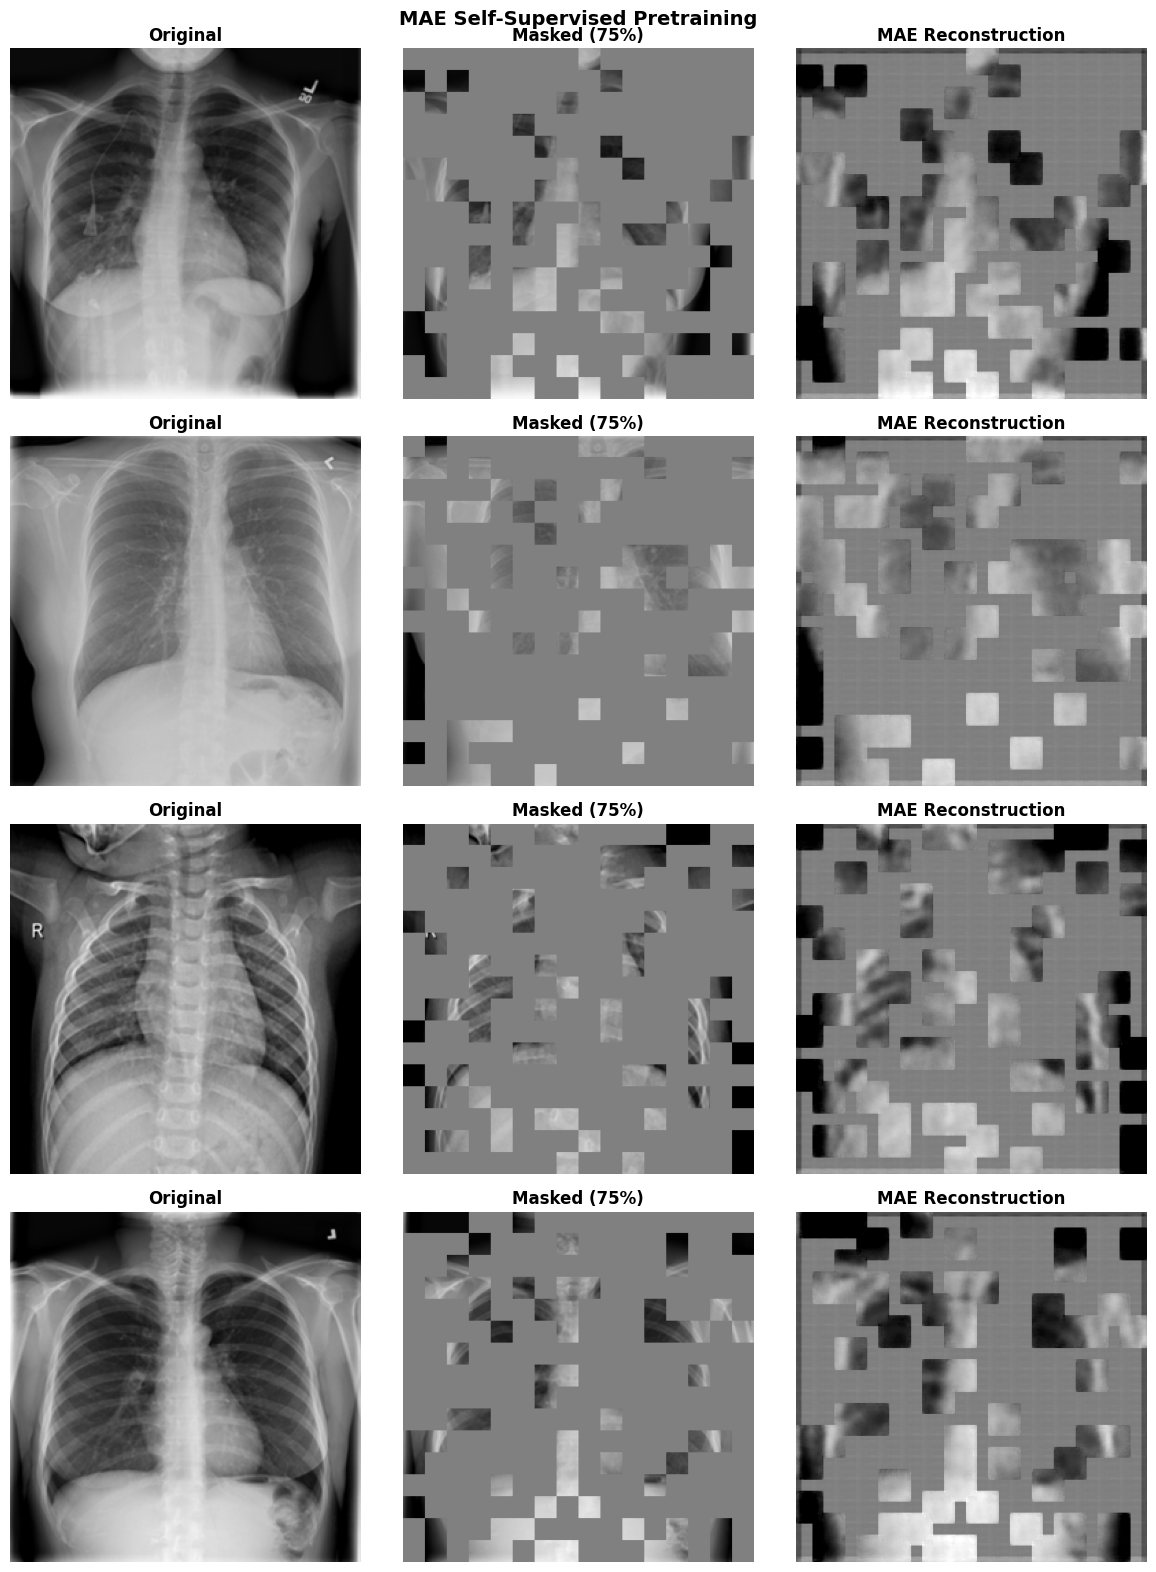


🔷 Starting Stage 2: Denoising Fine-tuning...

STAGE 2: DENOISING FINE-TUNING (SUPERVISED)
Epochs: 30
Learning rate: 0.0001



Finetune Epoch 1/30: 100%|██████████| 94/94 [00:19<00:00,  4.75it/s, loss=0.0087]



Epoch 1/30
  Train Loss: 0.0142
  Val Loss:   0.0053
  Val PSNR:   29.11 dB
  Val SSIM:   0.7707
  LR:         0.000100
  ✓ New best model! PSNR: 29.11 dB


Finetune Epoch 2/30: 100%|██████████| 94/94 [00:19<00:00,  4.78it/s, loss=0.0046]



Epoch 2/30
  Train Loss: 0.0069
  Val Loss:   0.0044
  Val PSNR:   29.87 dB
  Val SSIM:   0.7980
  LR:         0.000100
  ✓ New best model! PSNR: 29.87 dB


Finetune Epoch 3/30: 100%|██████████| 94/94 [00:19<00:00,  4.75it/s, loss=0.0060]



Epoch 3/30
  Train Loss: 0.0059
  Val Loss:   0.0040
  Val PSNR:   30.32 dB
  Val SSIM:   0.8156
  LR:         0.000100
  ✓ New best model! PSNR: 30.32 dB


Finetune Epoch 4/30: 100%|██████████| 94/94 [00:19<00:00,  4.72it/s, loss=0.0044]



Epoch 4/30
  Train Loss: 0.0061
  Val Loss:   0.0041
  Val PSNR:   30.21 dB
  Val SSIM:   0.8174
  LR:         0.000100


Finetune Epoch 5/30: 100%|██████████| 94/94 [00:19<00:00,  4.79it/s, loss=0.0043]



Epoch 5/30
  Train Loss: 0.0057
  Val Loss:   0.0037
  Val PSNR:   30.52 dB
  Val SSIM:   0.8174
  LR:         0.000100
  ✓ New best model! PSNR: 30.52 dB


Finetune Epoch 6/30: 100%|██████████| 94/94 [00:19<00:00,  4.77it/s, loss=0.0038]



Epoch 6/30
  Train Loss: 0.0053
  Val Loss:   0.0036
  Val PSNR:   30.66 dB
  Val SSIM:   0.8251
  LR:         0.000100
  ✓ New best model! PSNR: 30.66 dB


Finetune Epoch 7/30: 100%|██████████| 94/94 [00:19<00:00,  4.76it/s, loss=0.0037]



Epoch 7/30
  Train Loss: 0.0056
  Val Loss:   0.0038
  Val PSNR:   30.44 dB
  Val SSIM:   0.8206
  LR:         0.000100


Finetune Epoch 8/30: 100%|██████████| 94/94 [00:19<00:00,  4.77it/s, loss=0.0036]



Epoch 8/30
  Train Loss: 0.0050
  Val Loss:   0.0051
  Val PSNR:   29.07 dB
  Val SSIM:   0.7932
  LR:         0.000100


Finetune Epoch 9/30: 100%|██████████| 94/94 [00:19<00:00,  4.80it/s, loss=0.0044]



Epoch 9/30
  Train Loss: 0.0052
  Val Loss:   0.0042
  Val PSNR:   29.93 dB
  Val SSIM:   0.8157
  LR:         0.000100


Finetune Epoch 10/30: 100%|██████████| 94/94 [00:19<00:00,  4.82it/s, loss=0.0040]



Epoch 10/30
  Train Loss: 0.0056
  Val Loss:   0.0036
  Val PSNR:   30.81 dB
  Val SSIM:   0.8349
  LR:         0.000100
  ✓ New best model! PSNR: 30.81 dB


Finetune Epoch 11/30: 100%|██████████| 94/94 [00:19<00:00,  4.72it/s, loss=0.0053]



Epoch 11/30
  Train Loss: 0.0054
  Val Loss:   0.0041
  Val PSNR:   30.12 dB
  Val SSIM:   0.8039
  LR:         0.000100


Finetune Epoch 12/30: 100%|██████████| 94/94 [00:19<00:00,  4.74it/s, loss=0.0051]



Epoch 12/30
  Train Loss: 0.0048
  Val Loss:   0.0043
  Val PSNR:   29.86 dB
  Val SSIM:   0.8164
  LR:         0.000100


Finetune Epoch 13/30: 100%|██████████| 94/94 [00:19<00:00,  4.83it/s, loss=0.0046]



Epoch 13/30
  Train Loss: 0.0049
  Val Loss:   0.0036
  Val PSNR:   30.58 dB
  Val SSIM:   0.8226
  LR:         0.000100


Finetune Epoch 14/30: 100%|██████████| 94/94 [00:19<00:00,  4.80it/s, loss=0.0053]



Epoch 14/30
  Train Loss: 0.0051
  Val Loss:   0.0040
  Val PSNR:   30.18 dB
  Val SSIM:   0.8100
  LR:         0.000100


Finetune Epoch 15/30: 100%|██████████| 94/94 [00:19<00:00,  4.76it/s, loss=0.0036]



Epoch 15/30
  Train Loss: 0.0051
  Val Loss:   0.0038
  Val PSNR:   30.49 dB
  Val SSIM:   0.8357
  LR:         0.000100


Finetune Epoch 16/30: 100%|██████████| 94/94 [00:19<00:00,  4.79it/s, loss=0.0039]



Epoch 16/30
  Train Loss: 0.0044
  Val Loss:   0.0047
  Val PSNR:   29.92 dB
  Val SSIM:   0.8165
  LR:         0.000100
  ⚠ LR reduced: 0.000100 → 0.000050


Finetune Epoch 17/30: 100%|██████████| 94/94 [00:19<00:00,  4.81it/s, loss=0.0037]



Epoch 17/30
  Train Loss: 0.0042
  Val Loss:   0.0034
  Val PSNR:   30.95 dB
  Val SSIM:   0.8405
  LR:         0.000050
  ✓ New best model! PSNR: 30.95 dB


Finetune Epoch 18/30: 100%|██████████| 94/94 [00:19<00:00,  4.75it/s, loss=0.0038]



Epoch 18/30
  Train Loss: 0.0042
  Val Loss:   0.0036
  Val PSNR:   30.60 dB
  Val SSIM:   0.8145
  LR:         0.000050


Finetune Epoch 19/30: 100%|██████████| 94/94 [00:19<00:00,  4.77it/s, loss=0.0031]



Epoch 19/30
  Train Loss: 0.0042
  Val Loss:   0.0032
  Val PSNR:   31.24 dB
  Val SSIM:   0.8440
  LR:         0.000050
  ✓ New best model! PSNR: 31.24 dB


Finetune Epoch 20/30: 100%|██████████| 94/94 [00:19<00:00,  4.77it/s, loss=0.0044]



Epoch 20/30
  Train Loss: 0.0042
  Val Loss:   0.0033
  Val PSNR:   31.09 dB
  Val SSIM:   0.8401
  LR:         0.000050


Finetune Epoch 21/30: 100%|██████████| 94/94 [00:19<00:00,  4.81it/s, loss=0.0036]



Epoch 21/30
  Train Loss: 0.0039
  Val Loss:   0.0033
  Val PSNR:   31.10 dB
  Val SSIM:   0.8431
  LR:         0.000050


Finetune Epoch 22/30: 100%|██████████| 94/94 [00:19<00:00,  4.81it/s, loss=0.0042]



Epoch 22/30
  Train Loss: 0.0041
  Val Loss:   0.0032
  Val PSNR:   31.14 dB
  Val SSIM:   0.8331
  LR:         0.000050


Finetune Epoch 23/30: 100%|██████████| 94/94 [00:19<00:00,  4.76it/s, loss=0.0035]



Epoch 23/30
  Train Loss: 0.0039
  Val Loss:   0.0032
  Val PSNR:   31.15 dB
  Val SSIM:   0.8375
  LR:         0.000050


Finetune Epoch 24/30: 100%|██████████| 94/94 [00:19<00:00,  4.82it/s, loss=0.0057]



Epoch 24/30
  Train Loss: 0.0040
  Val Loss:   0.0031
  Val PSNR:   31.25 dB
  Val SSIM:   0.8412
  LR:         0.000050
  ✓ New best model! PSNR: 31.25 dB


Finetune Epoch 25/30: 100%|██████████| 94/94 [00:19<00:00,  4.78it/s, loss=0.0033]



Epoch 25/30
  Train Loss: 0.0038
  Val Loss:   0.0032
  Val PSNR:   31.10 dB
  Val SSIM:   0.8368
  LR:         0.000050


Finetune Epoch 26/30: 100%|██████████| 94/94 [00:19<00:00,  4.78it/s, loss=0.0035]



Epoch 26/30
  Train Loss: 0.0038
  Val Loss:   0.0031
  Val PSNR:   31.35 dB
  Val SSIM:   0.8478
  LR:         0.000050
  ✓ New best model! PSNR: 31.35 dB


Finetune Epoch 27/30: 100%|██████████| 94/94 [00:19<00:00,  4.74it/s, loss=0.0033]



Epoch 27/30
  Train Loss: 0.0038
  Val Loss:   0.0031
  Val PSNR:   31.32 dB
  Val SSIM:   0.8390
  LR:         0.000050


Finetune Epoch 28/30: 100%|██████████| 94/94 [00:19<00:00,  4.83it/s, loss=0.0045]



Epoch 28/30
  Train Loss: 0.0039
  Val Loss:   0.0030
  Val PSNR:   31.42 dB
  Val SSIM:   0.8476
  LR:         0.000050
  ✓ New best model! PSNR: 31.42 dB


Finetune Epoch 29/30: 100%|██████████| 94/94 [00:19<00:00,  4.78it/s, loss=0.0038]



Epoch 29/30
  Train Loss: 0.0038
  Val Loss:   0.0031
  Val PSNR:   31.36 dB
  Val SSIM:   0.8422
  LR:         0.000050


Finetune Epoch 30/30: 100%|██████████| 94/94 [00:19<00:00,  4.78it/s, loss=0.0051]



Epoch 30/30
  Train Loss: 0.0037
  Val Loss:   0.0030
  Val PSNR:   31.39 dB
  Val SSIM:   0.8470
  LR:         0.000050

FINE-TUNING COMPLETE!
Best PSNR: 31.42 dB (Epoch 28)
Best SSIM: 0.8478

Saving denoising comparison images...
✓ Saved 8 comparison images to /content/drive/MyDrive/xray_denoising_dataset/mae_denoising_results

🔷 Starting Stage 3: Latent Space Visualization...

1. PCA visualization...

Extracting latent representations using PCA...
Latent representations shape: (500, 256)
PCA explained variance: 0.893, 0.058


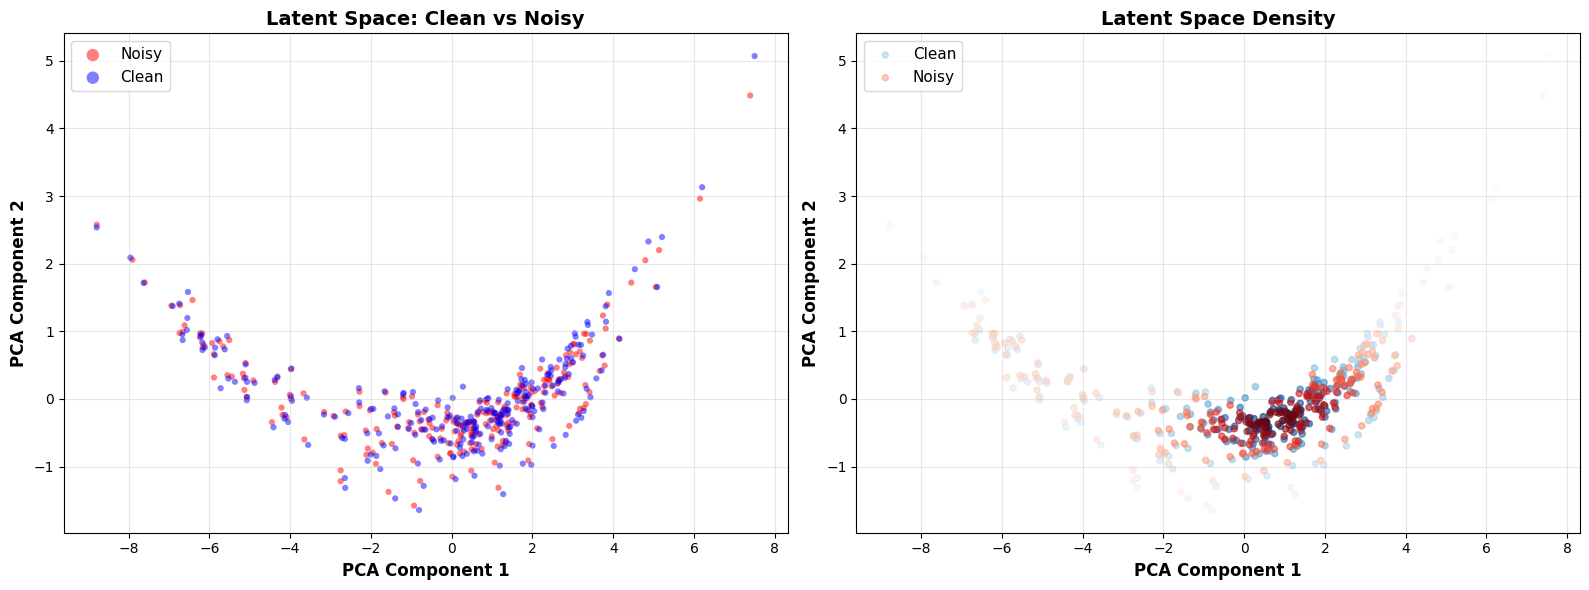

✓ Latent space visualization saved to /content/drive/MyDrive/xray_denoising_dataset/latent_space_pca.png

2. t-SNE visualization (this may take a few minutes)...

Extracting latent representations using TSNE...
Latent representations shape: (300, 256)


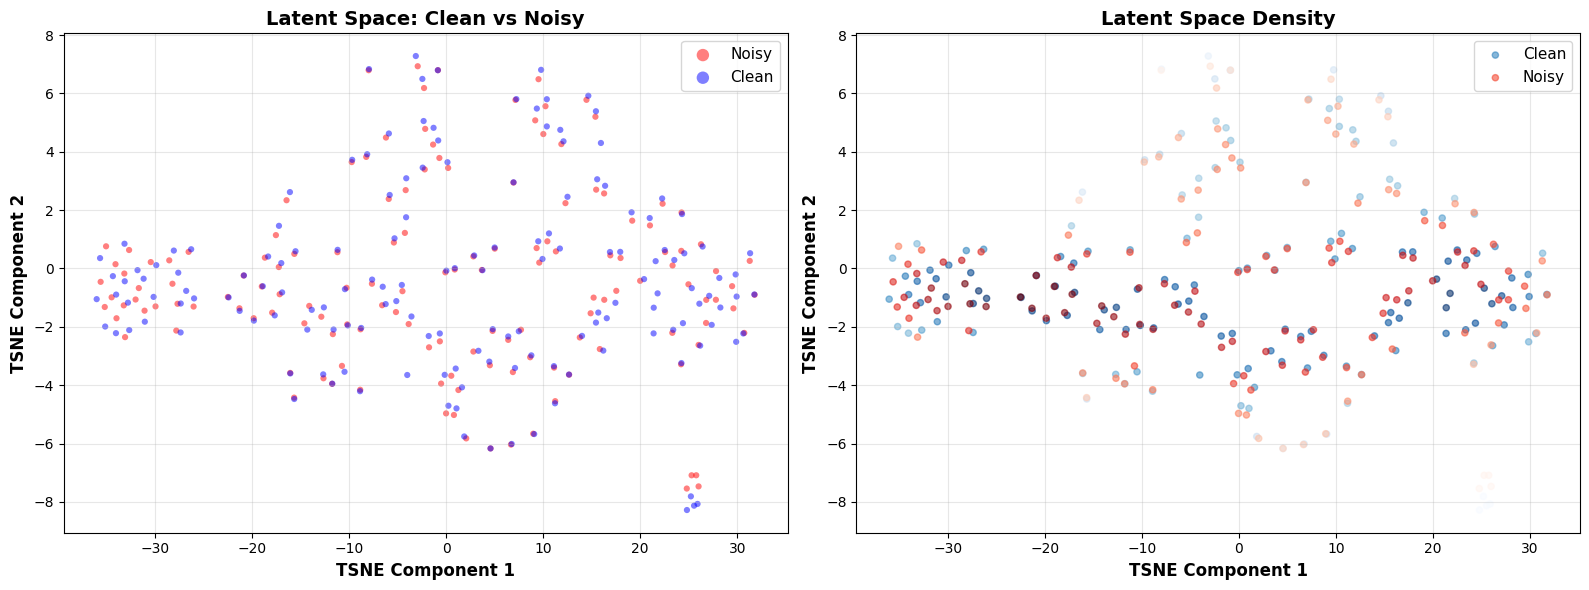

✓ Latent space visualization saved to /content/drive/MyDrive/xray_denoising_dataset/latent_space_tsne.png

3. Patch embeddings visualization...


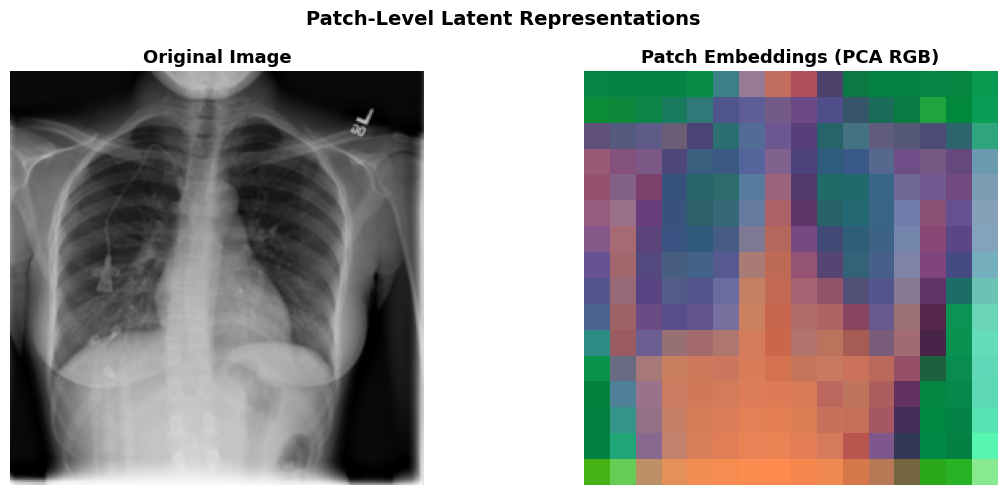

✓ Patch embeddings visualization saved

4. Attention maps visualization...


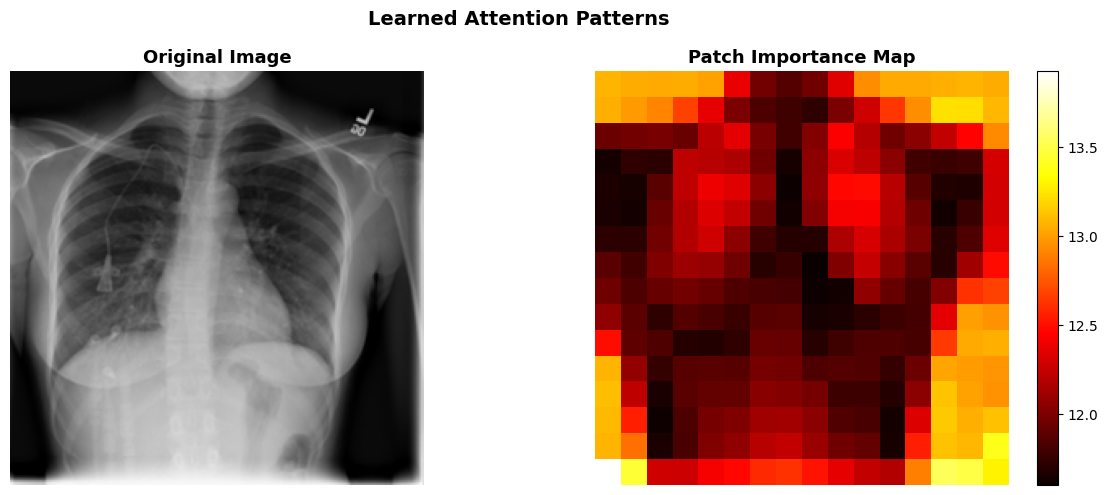

✓ Attention maps saved

MAE TRAINING COMPLETE!

📊 PRETRAINING RESULTS:
  Final Loss: 0.1548
  Final PSNR: 14.34 dB

📊 FINE-TUNING RESULTS:
  Best PSNR:  31.42 dB
  Best SSIM:  0.8478
  Final PSNR: 31.39 dB
  Final SSIM: 0.8470

📁 SAVED FILES:
  • mae_pretrained_final.pth
  • mae_denoising_best.pth
  • mae_denoising_results/
  • latent_space_pca.png
  • latent_space_tsne.png
  • patch_embeddings.png
  • attention_maps.png

✅ All training stages completed successfully!

✓ Summary saved to /content/drive/MyDrive/xray_denoising_dataset/mae_training_summary.txt


In [11]:
# ============================================================================
# CELL 8: Execute Complete MAE Training Pipeline
# ============================================================================

print("="*70)
print("MAE-ENHANCED DENOISING AUTOENCODER - COMPLETE TRAINING")
print("="*70)
print("\nThis will execute:")
print("  Stage 1: MAE Pretraining (Self-Supervised) - 20 epochs")
print("  Stage 2: Denoising Fine-tuning (Supervised) - 30 epochs")
print("  Stage 3: Latent Space Visualization")
print("="*70)

# Configuration
PRETRAIN_EPOCHS = 20
FINETUNE_EPOCHS = 30
MASK_RATIO = 0.75  # 75% masking for MAE

# ============================================================================
# STAGE 1: MAE PRETRAINING (Self-Supervised)
# ============================================================================

print("\n🔷 Starting Stage 1: MAE Pretraining...")
pretrain_history = pretrain_mae(
    model=model,
    train_loader=train_loader,
    num_epochs=PRETRAIN_EPOCHS,
    learning_rate=1e-3,
    mask_ratio=MASK_RATIO,
    save_dir=output_dir
)

# Visualize MAE reconstruction after pretraining
print("\nVisualizing MAE masked reconstruction...")
visualize_mae_reconstruction(model, val_loader, mask_ratio=MASK_RATIO)

# ============================================================================
# STAGE 2: DENOISING FINE-TUNING (Supervised)
# ============================================================================

print("\n🔷 Starting Stage 2: Denoising Fine-tuning...")
finetune_history = finetune_denoising(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=FINETUNE_EPOCHS,
    learning_rate=1e-4,
    save_dir=output_dir
)

# Save denoising results
print("\nSaving denoising comparison images...")
save_denoising_comparisons(model, val_loader, output_dir, num_samples=8)

# ============================================================================
# STAGE 3: LATENT SPACE VISUALIZATION
# ============================================================================

print("\n🔷 Starting Stage 3: Latent Space Visualization...")

# Install scikit-learn if needed
try:
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
except:
    print("Installing scikit-learn...")
    !pip install scikit-learn -q
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE

# Visualize latent space with PCA
print("\n1. PCA visualization...")
visualize_latent_space(model, val_loader, method='pca', num_samples=500)

# Visualize latent space with t-SNE
print("\n2. t-SNE visualization (this may take a few minutes)...")
visualize_latent_space(model, val_loader, method='tsne', num_samples=300)

# Get a sample for detailed visualization
sample_batch = next(iter(val_loader))
sample_clean = sample_batch['clean'][:1]
sample_noisy = sample_batch['noisy'][:1]

# Visualize patch embeddings
print("\n3. Patch embeddings visualization...")
visualize_patch_embeddings(model, sample_clean)

# Visualize attention maps
print("\n4. Attention maps visualization...")
visualize_attention_maps(model, sample_clean)

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*70)
print("MAE TRAINING COMPLETE!")
print("="*70)
print("\n📊 PRETRAINING RESULTS:")
print(f"  Final Loss: {pretrain_history['loss'][-1]:.4f}")
print(f"  Final PSNR: {pretrain_history['psnr'][-1]:.2f} dB")

print("\n📊 FINE-TUNING RESULTS:")
print(f"  Best PSNR:  {max(finetune_history['val_psnr']):.2f} dB")
print(f"  Best SSIM:  {max(finetune_history['val_ssim']):.4f}")
print(f"  Final PSNR: {finetune_history['val_psnr'][-1]:.2f} dB")
print(f"  Final SSIM: {finetune_history['val_ssim'][-1]:.4f}")

print("\n📁 SAVED FILES:")
print(f"  • mae_pretrained_final.pth")
print(f"  • mae_denoising_best.pth")
print(f"  • mae_denoising_results/")
print(f"  • latent_space_pca.png")
print(f"  • latent_space_tsne.png")
print(f"  • patch_embeddings.png")
print(f"  • attention_maps.png")

print("\n✅ All training stages completed successfully!")
print("="*70)

# Save final summary
with open(os.path.join(output_dir, 'mae_training_summary.txt'), 'w') as f:
    f.write("MAE-Enhanced Denoising Autoencoder - Training Summary\n")
    f.write("="*70 + "\n\n")
    f.write("PRETRAINING (Self-Supervised):\n")
    f.write(f"  Epochs: {PRETRAIN_EPOCHS}\n")
    f.write(f"  Mask Ratio: {MASK_RATIO}\n")
    f.write(f"  Final Loss: {pretrain_history['loss'][-1]:.4f}\n")
    f.write(f"  Final PSNR: {pretrain_history['psnr'][-1]:.2f} dB\n\n")
    f.write("FINE-TUNING (Supervised Denoising):\n")
    f.write(f"  Epochs: {FINETUNE_EPOCHS}\n")
    f.write(f"  Best PSNR: {max(finetune_history['val_psnr']):.2f} dB\n")
    f.write(f"  Best SSIM: {max(finetune_history['val_ssim']):.4f}\n")

print(f"\n✓ Summary saved to {output_dir}/mae_training_summary.txt")

ABLATION STUDY: MAE Pretraining Impact

Training a second model WITHOUT MAE pretraining for comparison...
This will show the benefit of self-supervised pretraining.

🔶 Training model WITHOUT MAE pretraining...
(Only supervised denoising from scratch)

STAGE 2: DENOISING FINE-TUNING (SUPERVISED)
Epochs: 30
Learning rate: 0.0001



Finetune Epoch 1/30: 100%|██████████| 94/94 [00:20<00:00,  4.60it/s, loss=0.0141]



Epoch 1/30
  Train Loss: 0.0469
  Val Loss:   0.0111
  Val PSNR:   25.77 dB
  Val SSIM:   0.6458
  LR:         0.000100
  ✓ New best model! PSNR: 25.77 dB


Finetune Epoch 2/30: 100%|██████████| 94/94 [00:19<00:00,  4.76it/s, loss=0.0077]



Epoch 2/30
  Train Loss: 0.0120
  Val Loss:   0.0077
  Val PSNR:   27.37 dB
  Val SSIM:   0.7181
  LR:         0.000100
  ✓ New best model! PSNR: 27.37 dB


Finetune Epoch 3/30: 100%|██████████| 94/94 [00:19<00:00,  4.87it/s, loss=0.0287]



Epoch 3/30
  Train Loss: 0.0103
  Val Loss:   0.0072
  Val PSNR:   27.69 dB
  Val SSIM:   0.7605
  LR:         0.000100
  ✓ New best model! PSNR: 27.69 dB


Finetune Epoch 4/30: 100%|██████████| 94/94 [00:19<00:00,  4.79it/s, loss=0.0075]



Epoch 4/30
  Train Loss: 0.0083
  Val Loss:   0.0060
  Val PSNR:   28.43 dB
  Val SSIM:   0.7641
  LR:         0.000100
  ✓ New best model! PSNR: 28.43 dB


Finetune Epoch 5/30: 100%|██████████| 94/94 [00:20<00:00,  4.60it/s, loss=0.0173]



Epoch 5/30
  Train Loss: 0.0075
  Val Loss:   0.0063
  Val PSNR:   28.25 dB
  Val SSIM:   0.7901
  LR:         0.000100


Finetune Epoch 6/30: 100%|██████████| 94/94 [00:19<00:00,  4.81it/s, loss=0.0056]



Epoch 6/30
  Train Loss: 0.0073
  Val Loss:   0.0050
  Val PSNR:   29.26 dB
  Val SSIM:   0.7826
  LR:         0.000100
  ✓ New best model! PSNR: 29.26 dB


Finetune Epoch 7/30: 100%|██████████| 94/94 [00:19<00:00,  4.81it/s, loss=0.0045]



Epoch 7/30
  Train Loss: 0.0067
  Val Loss:   0.0045
  Val PSNR:   29.78 dB
  Val SSIM:   0.8029
  LR:         0.000100
  ✓ New best model! PSNR: 29.78 dB


Finetune Epoch 8/30: 100%|██████████| 94/94 [00:19<00:00,  4.80it/s, loss=0.0044]



Epoch 8/30
  Train Loss: 0.0065
  Val Loss:   0.0046
  Val PSNR:   29.61 dB
  Val SSIM:   0.7956
  LR:         0.000100


Finetune Epoch 9/30: 100%|██████████| 94/94 [00:19<00:00,  4.83it/s, loss=0.0062]



Epoch 9/30
  Train Loss: 0.0072
  Val Loss:   0.0073
  Val PSNR:   27.53 dB
  Val SSIM:   0.8055
  LR:         0.000100


Finetune Epoch 10/30: 100%|██████████| 94/94 [00:19<00:00,  4.82it/s, loss=0.0042]



Epoch 10/30
  Train Loss: 0.0060
  Val Loss:   0.0047
  Val PSNR:   29.45 dB
  Val SSIM:   0.8070
  LR:         0.000100


Finetune Epoch 11/30: 100%|██████████| 94/94 [00:19<00:00,  4.75it/s, loss=0.0086]



Epoch 11/30
  Train Loss: 0.0064
  Val Loss:   0.0044
  Val PSNR:   29.75 dB
  Val SSIM:   0.8086
  LR:         0.000100


Finetune Epoch 12/30: 100%|██████████| 94/94 [00:19<00:00,  4.81it/s, loss=0.0041]



Epoch 12/30
  Train Loss: 0.0065
  Val Loss:   0.0046
  Val PSNR:   29.66 dB
  Val SSIM:   0.8211
  LR:         0.000100


Finetune Epoch 13/30: 100%|██████████| 94/94 [00:19<00:00,  4.84it/s, loss=0.0051]



Epoch 13/30
  Train Loss: 0.0068
  Val Loss:   0.0046
  Val PSNR:   29.69 dB
  Val SSIM:   0.8024
  LR:         0.000100


Finetune Epoch 14/30: 100%|██████████| 94/94 [00:19<00:00,  4.83it/s, loss=0.0152]



Epoch 14/30
  Train Loss: 0.0061
  Val Loss:   0.0039
  Val PSNR:   30.33 dB
  Val SSIM:   0.8183
  LR:         0.000100
  ✓ New best model! PSNR: 30.33 dB


Finetune Epoch 15/30: 100%|██████████| 94/94 [00:20<00:00,  4.70it/s, loss=0.0043]



Epoch 15/30
  Train Loss: 0.0060
  Val Loss:   0.0039
  Val PSNR:   30.40 dB
  Val SSIM:   0.8278
  LR:         0.000100
  ✓ New best model! PSNR: 30.40 dB


Finetune Epoch 16/30: 100%|██████████| 94/94 [00:19<00:00,  4.80it/s, loss=0.0046]



Epoch 16/30
  Train Loss: 0.0055
  Val Loss:   0.0041
  Val PSNR:   30.18 dB
  Val SSIM:   0.8256
  LR:         0.000100


Finetune Epoch 17/30: 100%|██████████| 94/94 [00:19<00:00,  4.82it/s, loss=0.0043]



Epoch 17/30
  Train Loss: 0.0056
  Val Loss:   0.0036
  Val PSNR:   30.66 dB
  Val SSIM:   0.8259
  LR:         0.000100
  ✓ New best model! PSNR: 30.66 dB


Finetune Epoch 18/30: 100%|██████████| 94/94 [00:19<00:00,  4.80it/s, loss=0.0040]



Epoch 18/30
  Train Loss: 0.0055
  Val Loss:   0.0038
  Val PSNR:   30.47 dB
  Val SSIM:   0.8185
  LR:         0.000100


Finetune Epoch 19/30: 100%|██████████| 94/94 [00:19<00:00,  4.83it/s, loss=0.0113]



Epoch 19/30
  Train Loss: 0.0055
  Val Loss:   0.0047
  Val PSNR:   29.46 dB
  Val SSIM:   0.8145
  LR:         0.000100


Finetune Epoch 20/30: 100%|██████████| 94/94 [00:19<00:00,  4.75it/s, loss=0.0061]



Epoch 20/30
  Train Loss: 0.0053
  Val Loss:   0.0035
  Val PSNR:   30.86 dB
  Val SSIM:   0.8351
  LR:         0.000100
  ✓ New best model! PSNR: 30.86 dB


Finetune Epoch 21/30: 100%|██████████| 94/94 [00:19<00:00,  4.79it/s, loss=0.0038]



Epoch 21/30
  Train Loss: 0.0053
  Val Loss:   0.0052
  Val PSNR:   28.97 dB
  Val SSIM:   0.8115
  LR:         0.000100


Finetune Epoch 22/30: 100%|██████████| 94/94 [00:19<00:00,  4.84it/s, loss=0.0035]



Epoch 22/30
  Train Loss: 0.0059
  Val Loss:   0.0044
  Val PSNR:   29.78 dB
  Val SSIM:   0.8082
  LR:         0.000100


Finetune Epoch 23/30: 100%|██████████| 94/94 [00:19<00:00,  4.84it/s, loss=0.0044]



Epoch 23/30
  Train Loss: 0.0054
  Val Loss:   0.0035
  Val PSNR:   30.84 dB
  Val SSIM:   0.8275
  LR:         0.000100


Finetune Epoch 24/30: 100%|██████████| 94/94 [00:19<00:00,  4.79it/s, loss=0.0041]



Epoch 24/30
  Train Loss: 0.0053
  Val Loss:   0.0042
  Val PSNR:   30.03 dB
  Val SSIM:   0.8357
  LR:         0.000100


Finetune Epoch 25/30: 100%|██████████| 94/94 [00:19<00:00,  4.81it/s, loss=0.0060]



Epoch 25/30
  Train Loss: 0.0052
  Val Loss:   0.0039
  Val PSNR:   30.28 dB
  Val SSIM:   0.8231
  LR:         0.000100


Finetune Epoch 26/30: 100%|██████████| 94/94 [00:19<00:00,  4.84it/s, loss=0.0040]



Epoch 26/30
  Train Loss: 0.0053
  Val Loss:   0.0034
  Val PSNR:   30.94 dB
  Val SSIM:   0.8382
  LR:         0.000100
  ✓ New best model! PSNR: 30.94 dB


Finetune Epoch 27/30: 100%|██████████| 94/94 [00:19<00:00,  4.80it/s, loss=0.0057]



Epoch 27/30
  Train Loss: 0.0051
  Val Loss:   0.0035
  Val PSNR:   30.86 dB
  Val SSIM:   0.8286
  LR:         0.000100


Finetune Epoch 28/30: 100%|██████████| 94/94 [00:19<00:00,  4.77it/s, loss=0.0097]



Epoch 28/30
  Train Loss: 0.0050
  Val Loss:   0.0040
  Val PSNR:   30.18 dB
  Val SSIM:   0.8138
  LR:         0.000100


Finetune Epoch 29/30: 100%|██████████| 94/94 [00:19<00:00,  4.80it/s, loss=0.0037]



Epoch 29/30
  Train Loss: 0.0051
  Val Loss:   0.0057
  Val PSNR:   28.57 dB
  Val SSIM:   0.8086
  LR:         0.000100


Finetune Epoch 30/30: 100%|██████████| 94/94 [00:19<00:00,  4.83it/s, loss=0.0063]



Epoch 30/30
  Train Loss: 0.0051
  Val Loss:   0.0033
  Val PSNR:   31.06 dB
  Val SSIM:   0.8374
  LR:         0.000100
  ✓ New best model! PSNR: 31.06 dB

FINE-TUNING COMPLETE!
Best PSNR: 31.06 dB (Epoch 30)
Best SSIM: 0.8382

📊 Creating comparison visualizations...


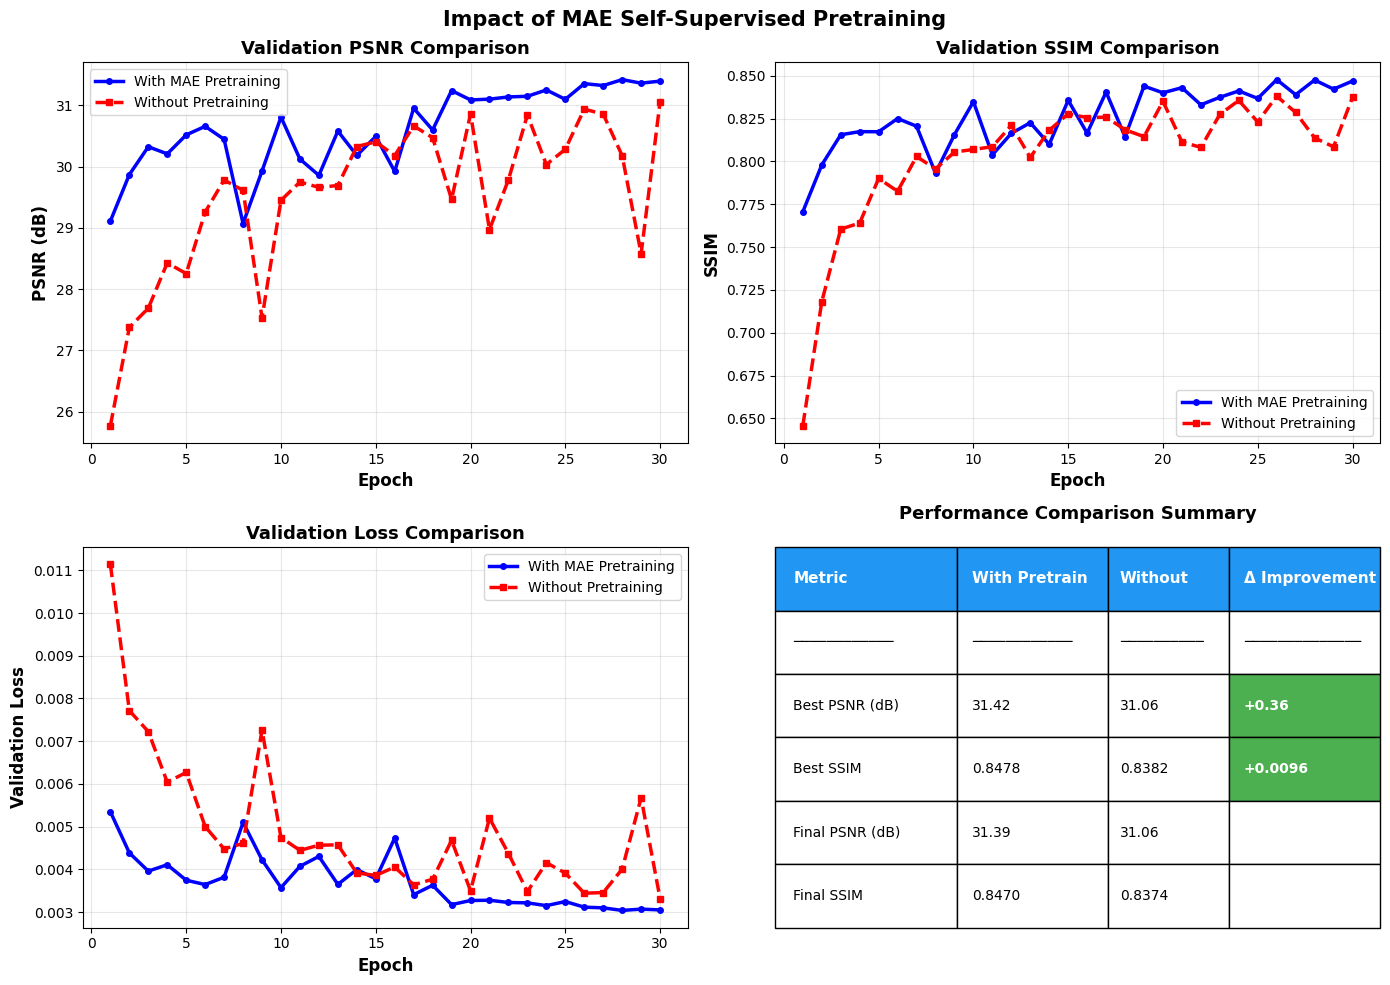


📸 Comparing visual denoising quality...


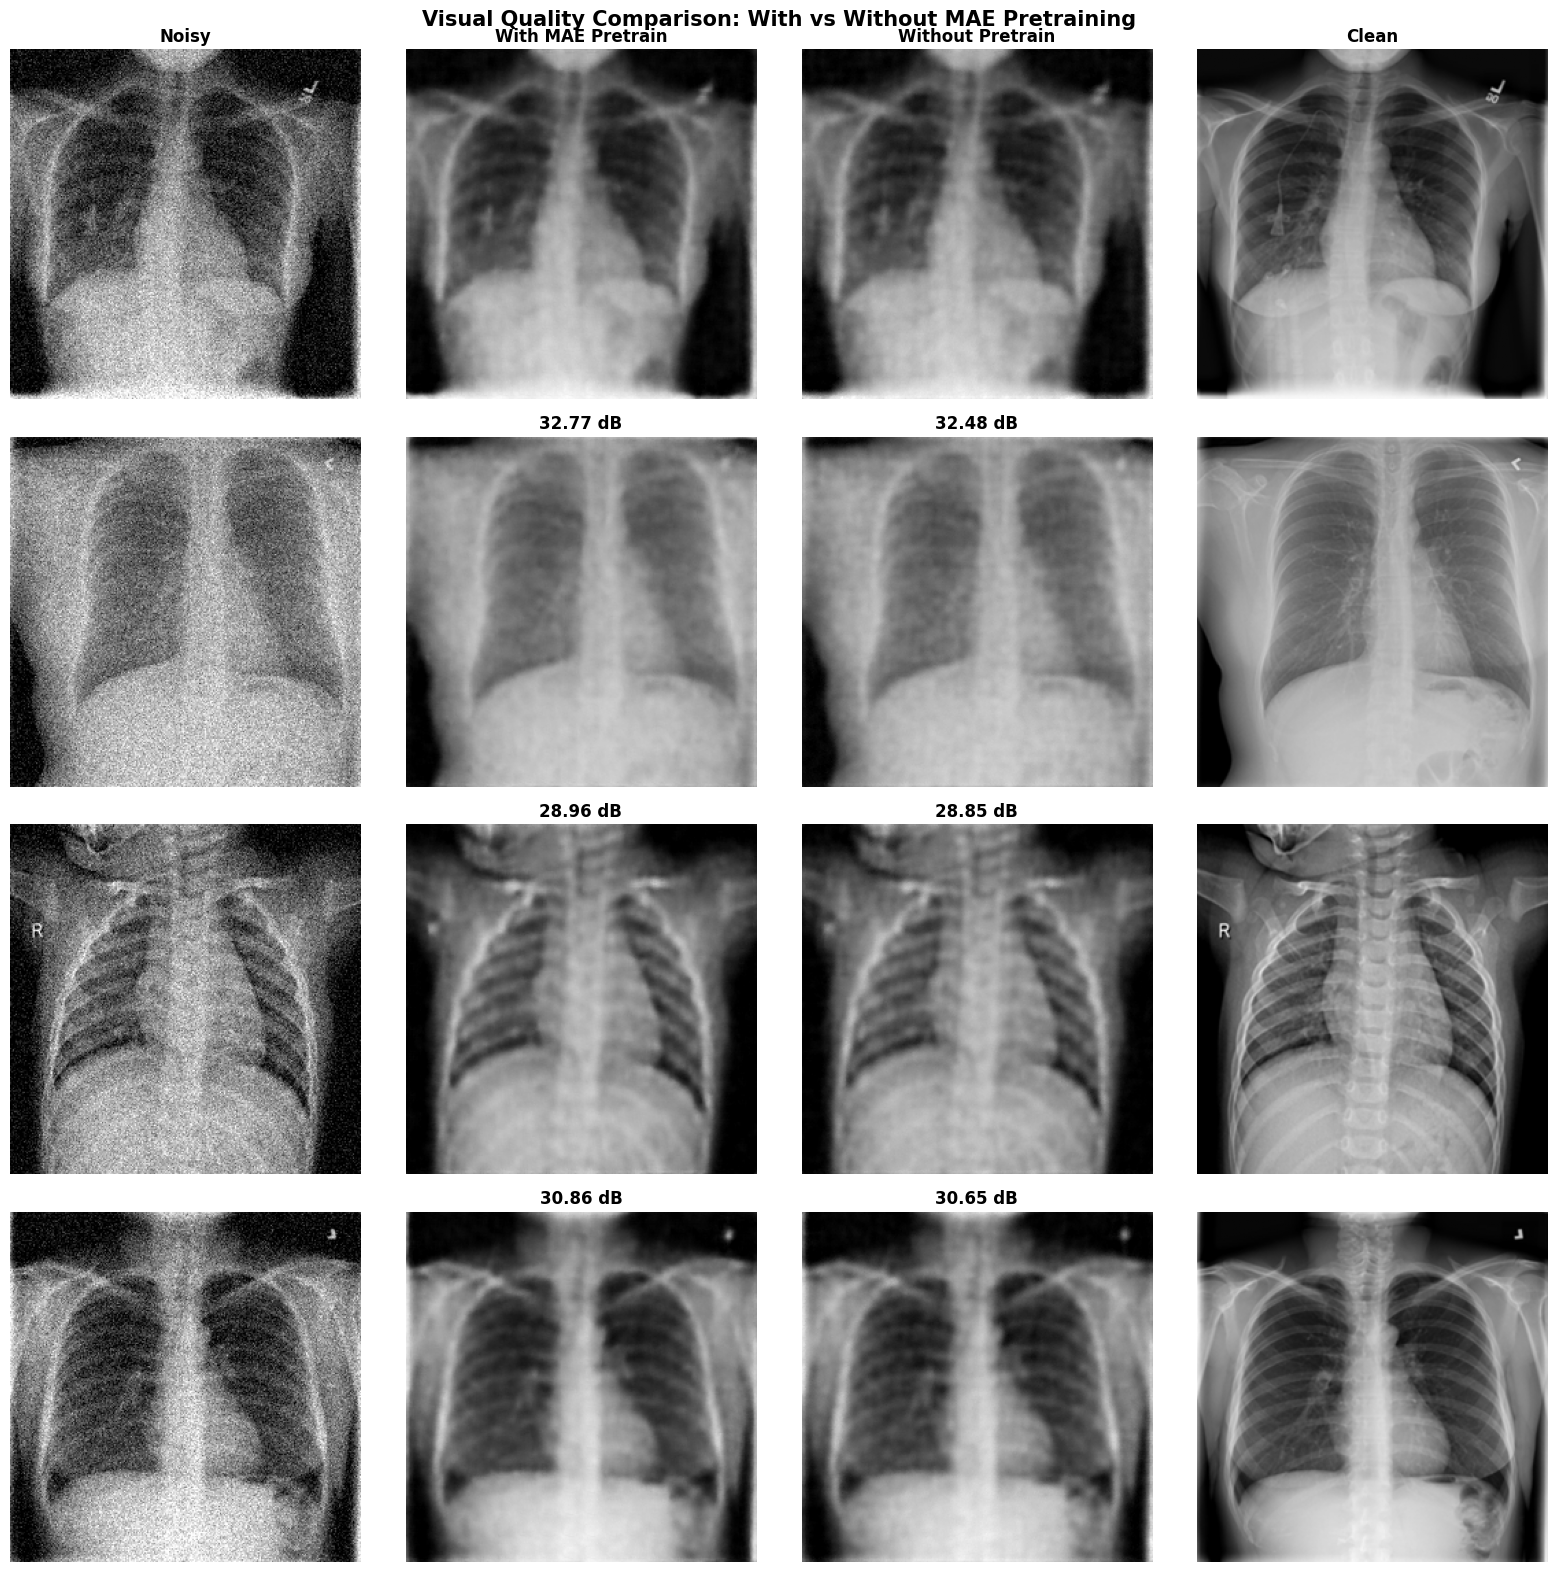


ABLATION STUDY RESULTS

✅ WITH MAE Pretraining:
   Best PSNR: 31.42 dB
   Best SSIM: 0.8478

❌ WITHOUT MAE Pretraining:
   Best PSNR: 31.06 dB
   Best SSIM: 0.8382

📈 IMPROVEMENT from MAE Pretraining:
   PSNR: +0.36 dB (1.2% relative)
   SSIM: +0.0096

🎉 MAE pretraining IMPROVES performance!

✓ Ablation results saved to /content/drive/MyDrive/xray_denoising_dataset/mae_ablation_results.txt


In [12]:
# ============================================================================
# CELL 9: Compare Performance WITH vs WITHOUT MAE Pretraining
# ============================================================================

print("="*70)
print("ABLATION STUDY: MAE Pretraining Impact")
print("="*70)
print("\nTraining a second model WITHOUT MAE pretraining for comparison...")
print("This will show the benefit of self-supervised pretraining.")
print("="*70)

# Create a new model (without pretraining)
model_no_pretrain = MAEDenoisingAutoencoder(
    img_size=256,
    patch_size=16,
    in_channels=1,
    embed_dim=256,
    depth=4,
    num_heads=8
).to(device)

print("\n🔶 Training model WITHOUT MAE pretraining...")
print("(Only supervised denoising from scratch)")

# Train directly on denoising (skip pretraining)
history_no_pretrain = finetune_denoising(
    model=model_no_pretrain,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=FINETUNE_EPOCHS,  # Same number of epochs
    learning_rate=1e-4,
    save_dir=output_dir
)

# Save this model too
torch.save({
    'model_state_dict': model_no_pretrain.state_dict(),
    'history': history_no_pretrain
}, os.path.join(output_dir, 'mae_no_pretrain_best.pth'))

# ============================================================================
# COMPARISON VISUALIZATION
# ============================================================================

print("\n📊 Creating comparison visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. PSNR Comparison
ax1 = axes[0, 0]
epochs = range(1, len(finetune_history['val_psnr']) + 1)
ax1.plot(epochs, finetune_history['val_psnr'], 'b-', linewidth=2.5,
        label='With MAE Pretraining', marker='o', markersize=4)
ax1.plot(epochs, history_no_pretrain['val_psnr'], 'r--', linewidth=2.5,
        label='Without Pretraining', marker='s', markersize=4)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('PSNR (dB)', fontsize=12, fontweight='bold')
ax1.set_title('Validation PSNR Comparison', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. SSIM Comparison
ax2 = axes[0, 1]
ax2.plot(epochs, finetune_history['val_ssim'], 'b-', linewidth=2.5,
        label='With MAE Pretraining', marker='o', markersize=4)
ax2.plot(epochs, history_no_pretrain['val_ssim'], 'r--', linewidth=2.5,
        label='Without Pretraining', marker='s', markersize=4)
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('SSIM', fontsize=12, fontweight='bold')
ax2.set_title('Validation SSIM Comparison', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Loss Comparison
ax3 = axes[1, 0]
ax3.plot(epochs, finetune_history['val_loss'], 'b-', linewidth=2.5,
        label='With MAE Pretraining', marker='o', markersize=4)
ax3.plot(epochs, history_no_pretrain['val_loss'], 'r--', linewidth=2.5,
        label='Without Pretraining', marker='s', markersize=4)
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
ax3.set_title('Validation Loss Comparison', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. Summary Table
ax4 = axes[1, 1]
ax4.axis('off')

best_psnr_with = max(finetune_history['val_psnr'])
best_psnr_without = max(history_no_pretrain['val_psnr'])
best_ssim_with = max(finetune_history['val_ssim'])
best_ssim_without = max(history_no_pretrain['val_ssim'])

psnr_improvement = best_psnr_with - best_psnr_without
ssim_improvement = best_ssim_with - best_ssim_without

summary_data = [
    ['Metric', 'With Pretrain', 'Without', 'Δ Improvement'],
    ['─'*12, '─'*12, '─'*10, '─'*14],
    ['Best PSNR (dB)', f'{best_psnr_with:.2f}',
     f'{best_psnr_without:.2f}', f'+{psnr_improvement:.2f}'],
    ['Best SSIM', f'{best_ssim_with:.4f}',
     f'{best_ssim_without:.4f}', f'+{ssim_improvement:.4f}'],
    ['Final PSNR (dB)', f"{finetune_history['val_psnr'][-1]:.2f}",
     f"{history_no_pretrain['val_psnr'][-1]:.2f}", ''],
    ['Final SSIM', f"{finetune_history['val_ssim'][-1]:.4f}",
     f"{history_no_pretrain['val_ssim'][-1]:.4f}", ''],
]

table = ax4.table(cellText=summary_data, loc='center', cellLoc='left',
                 colWidths=[0.3, 0.25, 0.2, 0.25],
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style header
for i in range(4):
    cell = table[(0, i)]
    cell.set_facecolor('#2196F3')
    cell.set_text_props(weight='bold', color='white', fontsize=11)

# Highlight improvements
if psnr_improvement > 0:
    table[(2, 3)].set_facecolor('#4CAF50')
    table[(2, 3)].set_text_props(weight='bold', color='white')
if ssim_improvement > 0:
    table[(3, 3)].set_facecolor('#4CAF50')
    table[(3, 3)].set_text_props(weight='bold', color='white')

ax4.set_title('Performance Comparison Summary', fontsize=13, fontweight='bold', pad=20)

plt.suptitle('Impact of MAE Self-Supervised Pretraining',
            fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'mae_pretrain_comparison.png'),
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# ============================================================================
# VISUAL QUALITY COMPARISON
# ============================================================================

print("\n📸 Comparing visual denoising quality...")

model.eval()
model_no_pretrain.eval()

with torch.no_grad():
    batch = next(iter(val_loader))
    clean = batch['clean'][:4].to(device)
    noisy = batch['noisy'][:4].to(device)

    # Denoise with both models
    denoised_with = model(noisy)
    denoised_without = model_no_pretrain(noisy)

    # Denormalize
    clean_np = (clean.cpu().numpy() * 0.5 + 0.5).clip(0, 1)
    noisy_np = (noisy.cpu().numpy() * 0.5 + 0.5).clip(0, 1)
    denoised_with_np = (denoised_with.cpu().numpy() * 0.5 + 0.5).clip(0, 1)
    denoised_without_np = (denoised_without.cpu().numpy() * 0.5 + 0.5).clip(0, 1)

    # Plot comparison
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))

    for i in range(4):
        # Noisy
        axes[i, 0].imshow(noisy_np[i, 0], cmap='gray', vmin=0, vmax=1)
        axes[i, 0].set_title('Noisy' if i==0 else '', fontsize=12, fontweight='bold')
        axes[i, 0].axis('off')

        # With pretraining
        psnr_with = psnr(clean_np[i, 0], denoised_with_np[i, 0], data_range=1.0)
        axes[i, 1].imshow(denoised_with_np[i, 0], cmap='gray', vmin=0, vmax=1)
        title = 'With MAE Pretrain' if i==0 else f'{psnr_with:.2f} dB'
        axes[i, 1].set_title(title, fontsize=12, fontweight='bold')
        axes[i, 1].axis('off')

        # Without pretraining
        psnr_without = psnr(clean_np[i, 0], denoised_without_np[i, 0], data_range=1.0)
        axes[i, 2].imshow(denoised_without_np[i, 0], cmap='gray', vmin=0, vmax=1)
        title = 'Without Pretrain' if i==0 else f'{psnr_without:.2f} dB'
        axes[i, 2].set_title(title, fontsize=12, fontweight='bold')
        axes[i, 2].axis('off')

        # Clean
        axes[i, 3].imshow(clean_np[i, 0], cmap='gray', vmin=0, vmax=1)
        axes[i, 3].set_title('Clean' if i==0 else '', fontsize=12, fontweight='bold')
        axes[i, 3].axis('off')

    plt.suptitle('Visual Quality Comparison: With vs Without MAE Pretraining',
                fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'mae_visual_comparison.png'),
               dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# FINAL RESULTS
# ============================================================================

print("\n" + "="*70)
print("ABLATION STUDY RESULTS")
print("="*70)
print("\n✅ WITH MAE Pretraining:")
print(f"   Best PSNR: {best_psnr_with:.2f} dB")
print(f"   Best SSIM: {best_ssim_with:.4f}")

print("\n❌ WITHOUT MAE Pretraining:")
print(f"   Best PSNR: {best_psnr_without:.2f} dB")
print(f"   Best SSIM: {best_ssim_without:.4f}")

print("\n📈 IMPROVEMENT from MAE Pretraining:")
print(f"   PSNR: +{psnr_improvement:.2f} dB ({psnr_improvement/best_psnr_without*100:.1f}% relative)")
print(f"   SSIM: +{ssim_improvement:.4f}")

if psnr_improvement > 0:
    print("\n🎉 MAE pretraining IMPROVES performance!")
else:
    print("\n⚠️  MAE pretraining shows minimal impact (may need more pretraining epochs)")

print("="*70)

# Save comparison results
with open(os.path.join(output_dir, 'mae_ablation_results.txt'), 'w') as f:
    f.write("MAE Pretraining Ablation Study\n")
    f.write("="*70 + "\n\n")
    f.write("WITH MAE Pretraining:\n")
    f.write(f"  Best PSNR: {best_psnr_with:.2f} dB\n")
    f.write(f"  Best SSIM: {best_ssim_with:.4f}\n\n")
    f.write("WITHOUT MAE Pretraining:\n")
    f.write(f"  Best PSNR: {best_psnr_without:.2f} dB\n")
    f.write(f"  Best SSIM: {best_ssim_without:.4f}\n\n")
    f.write("Improvement:\n")
    f.write(f"  PSNR: +{psnr_improvement:.2f} dB\n")
    f.write(f"  SSIM: +{ssim_improvement:.4f}\n")

print(f"\n✓ Ablation results saved to {output_dir}/mae_ablation_results.txt")